In [9]:
import collections
import itertools
import logging
import random
import sys
from collections import deque

import numpy as np

import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle

import seaborn as sns

import gym
import pfrl

import torch
import tqdm as tqdm

from torch import nn
from gym.wrappers import RescaleAction

from util.ppo import PPO_KL
from util.modules import ortho_init, BetaPolicyModel

logging.basicConfig(level=logging.INFO, stream=sys.stdout)
logger = logging.getLogger(__name__)

sns.set()
sns.set_context("poster")

In [2]:
##########################################################
# Seed
##########################################################

seed = 100

random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
torch.cuda.manual_seed(seed)

##########################################################
# Environment params
##########################################################

env_id = "thermal_regulation:SmallLowGearAntTHR-v3"

temp_diff = (42. - 38.) / 6.0
env_config = {"max_episode_steps": np.inf,
              "internal_reset": "setpoint",
              "reward_setting": "homeostatic",
              "reward_bias": 0.0,
              "coef_main_rew": 0.0,
              "coef_ctrl_cost": 0.0,
              "coef_head_angle": 0.0,
              }

def get_env(seed=100, n_energy=6):
    env = gym.make(
        env_id,
        max_episode_steps=env_config["max_episode_steps"],
        internal_reset=env_config["internal_reset"],
        reward_setting=env_config["reward_setting"],
        reward_bias=env_config["reward_bias"],
        coef_main_rew=env_config["coef_main_rew"],
        coef_ctrl_cost=env_config["coef_ctrl_cost"],
        coef_head_angle=env_config["coef_head_angle"],
        n_bins=20,
        sensor_range=16,
        n_energy=n_energy,
        visualize_temp=True,
    )

    env.seed(seed)

    env = RescaleAction(env, 0, 1)

    env = pfrl.wrappers.CastObservationToFloat32(env)
    return env

##########################################################
# Load Agent
##########################################################
env = get_env()

obs_space = env.observation_space
action_space = env.action_space

obs_size = obs_space.low.size
action_size = action_space.low.size

policy = BetaPolicyModel(obs_size=obs_size,
                         action_size=action_size,
                         hidden1=256,
                         hidden2=64)

value_func = torch.nn.Sequential(
    nn.Linear(obs_size, 256),
    nn.Tanh(),
    nn.Linear(256, 64),
    nn.Tanh(),
    nn.Linear(64, 1),
)

model = pfrl.nn.Branched(policy, value_func)

opt = torch.optim.Adam(model.parameters())

agent = PPO_KL(
    model=model,
    optimizer=opt,
    gpu=-1,
)

class sliceable_deque(collections.deque):
    def __getitem__(self, index):
        try:
            return collections.deque.__getitem__(self, index)
        except TypeError:
            return type(self)(itertools.islice(self, index.start,
                                               index.stop, index.step))

# agent.load(dirname="data/therm-homeostatic_shaped2021-08-31-19-07-17/150000000_finish")

# agent.load(dirname="data/result_trp_therm_oct2021/therm-homeostatic_shaped2021-10-04-17-09-23/150000000_finish")

# new params
# agent.load(dirname="data/result_trp_therm_oct2021/therm-homeostatic_shaped2021-10-04-17-08-38/150000000_finish")
# agent.load(dirname="data/result_trp_therm_oct2021/therm-homeostatic_shaped2021-10-04-17-09-23/150000000_finish")
# agent.load(dirname="data/result_trp_therm_oct2021/therm-homeostatic_shaped2021-10-06-11-33-32/150000000_finish")

#agent.load(dirname="data/result_trp_therm_oct2021/therm-homeostatic_shaped2021-10-08-12-40-17/150000000_finish")
agent.load(dirname="data/result_trp_therm_oct2021/therm-homeostatic_shaped2021-10-08-16-13-59/150000000_finish")

Error: A module (thermal_regulation) was specified for the environment but was not found, make sure the package is installed with `pip install` before calling `gym.make()`

In [3]:
# np.save("time_tick.npy", time_tictime_tickave("energy_hist.npy", energy_hist)
# np.save("temp_hist.npy", temp_hist)
# np.save("activity_hist.npy", activity_hist)
# np.save("ev_action_hist.npy", ev_action_hist)
# np.save("shade_hist.npy", shade_hist)

In [4]:
# with agent.eval_mode():
#     total_step = 0
#     obs = env.reset()
#     for t in range(10000):
#         env.render()

#         action = agent.act(obs)
#         total_step += 1

#         obs, r, done, _ = env.step(action)
#         if done:
#             logger.info("Reset.: " + str(total_step))
#             break

# Showing the trajectory

In [10]:
WINDOW_AVE = 10
MAX_DATA = 200000

In [6]:
env = get_env(seed=0, n_energy=3)

energy_hist = sliceable_deque(maxlen=MAX_DATA)
temp_hist = sliceable_deque(maxlen=MAX_DATA)
activity_hist = sliceable_deque(maxlen=MAX_DATA)
ev_action_hist = sliceable_deque(maxlen=MAX_DATA)

food_eaten_t = []

with agent.eval_mode():
    total_step = 0
    energy_record = deque(maxlen=WINDOW_AVE)
    temp_record = deque(maxlen=WINDOW_AVE)
    activity_record = deque(maxlen=WINDOW_AVE)
    ev_action_record = deque(maxlen=WINDOW_AVE)

    obs = env.reset()

#     key_e, key_t = env.internal_state.keys()
#     env.internal_state[key_e] = 0.0
#     env.internal_state[key_t] = 0.0
#     env.thermal_model.reset(env.decode_temperature(0.3))
#     print(env.get_interoception())

#     obs = env.get_current_obs().astype(np.float32)

    for i in tqdm.tqdm(range(MAX_DATA)):
        action = agent.act(obs)
        total_step += 1

        obs, r, done, _ = env.step(action)

#         key_e, key_t = env.internal_state.keys()
#         env.internal_state[key_t] = 0.0
#         env.thermal_model.reset(env.decode_temperature(0.0))
#         obs = env.get_current_obs().astype(np.float32)

        energy_now, temp_now = env.get_interoception()
        motor_action = 2 * (action[:-1] - 0.5)
        activity = np.sqrt(sum(np.square(motor_action))/motor_action.size)
        evaporative_action = 2 * (action[-1] - 0.5)

        energy_record.append(energy_now)
        temp_record.append(temp_now)
        activity_record.append(activity)
        ev_action_record.append(evaporative_action)

        energy_hist.append(energy_now)
        temp_hist.append(temp_now)

        activity_hist.append(np.mean(activity_record))
        ev_action_hist.append(np.mean(ev_action_record))

        if env.num_food_eaten > 0:
            food_eaten_t.append(i)

        if done:
            logger.info("Reset.: " + str(total_step))
            break
env.close()

print(len(food_eaten_t))

  3%|█████▏                                                                                                                                                    | 6678/200000 [00:28<13:57, 230.79it/s]


KeyboardInterrupt: 

In [11]:
# np.save("energy_hist.npy", energy_hist)
# np.save("temp_hist.npy", temp_hist)
# np.save("activity_hist.npy", activity_hist)
# np.save("ev_action_hist.npy", ev_action_hist)
# np.save("food_eaten_t.npy", np.array(food_eaten_t))

energy_hist = np.load("energy_hist.npy")
temp_hist = np.load("temp_hist.npy")
activity_hist = np.load("activity_hist.npy")
ev_action_hist = np.load("ev_action_hist.npy")
food_eaten_t = np.load("food_eaten_t.npy")

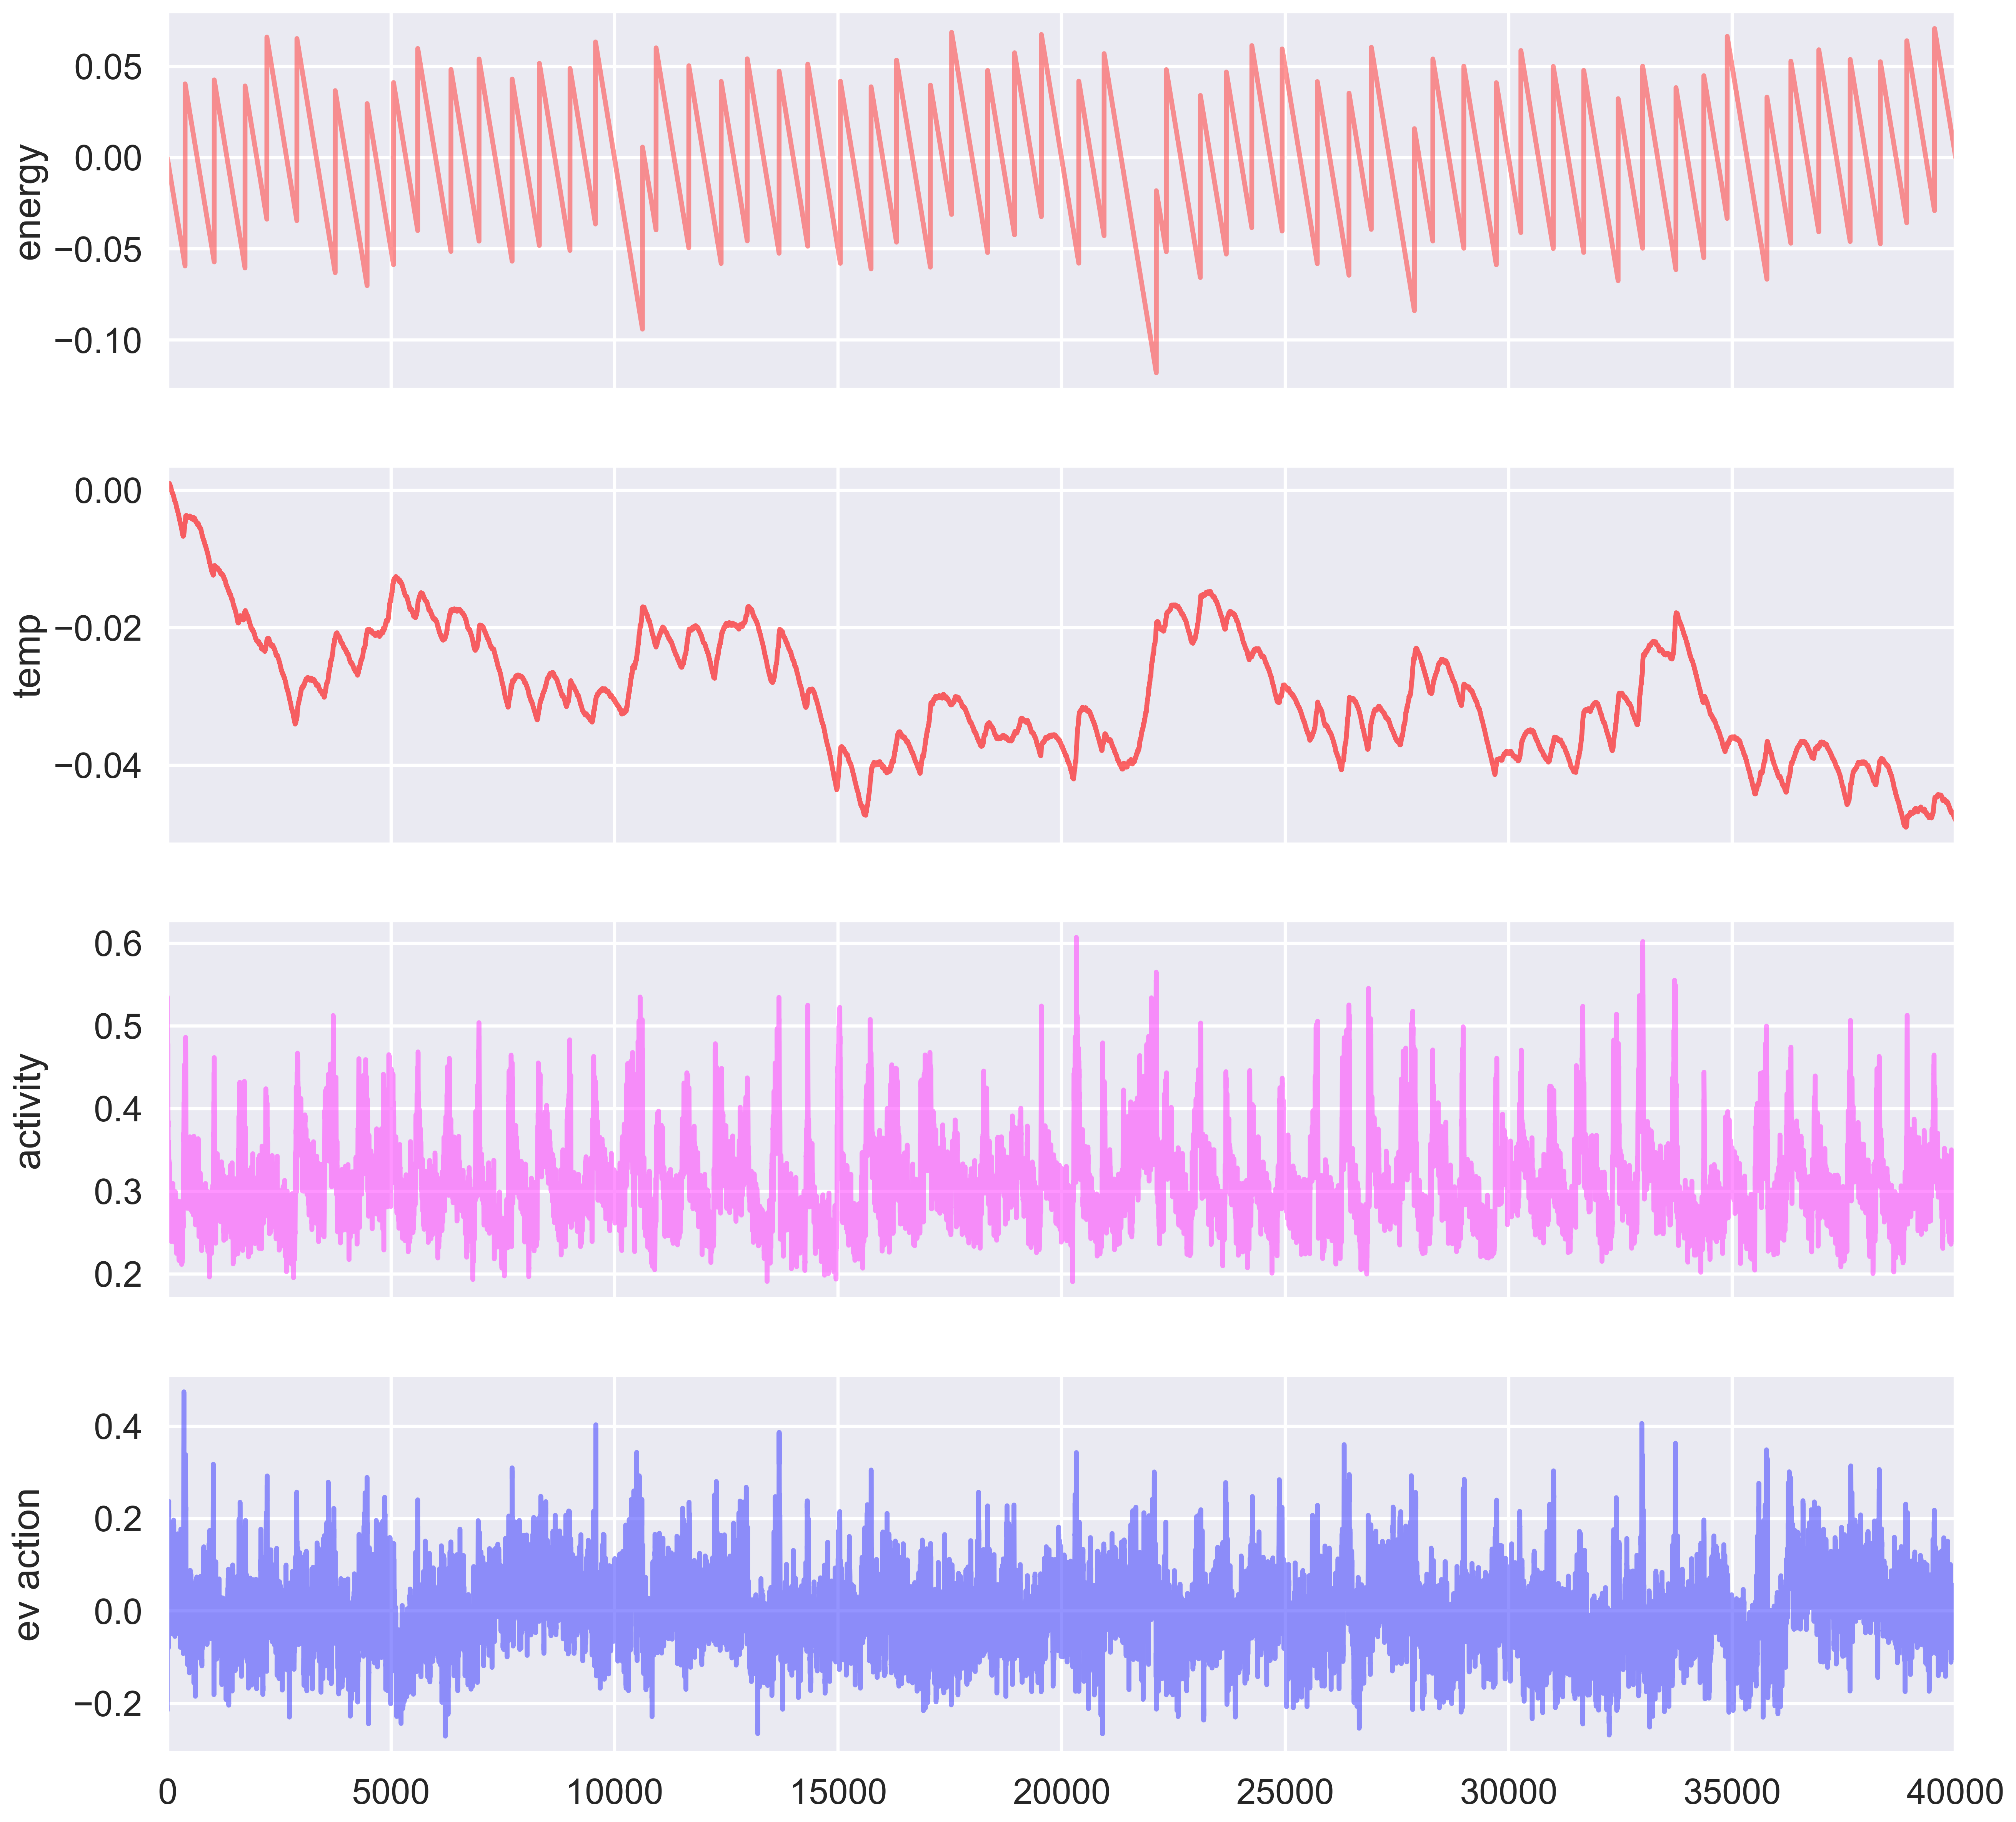

In [12]:
fig = plt.figure(figsize=(20, 20), dpi=300)
plt.legend(["energy", "core temperature", "activity", "ev action"])

time_tick = np.arange(len(energy_hist))

start = 0
end = 40000 # MAX_DATA

# plt.subplot(511)
# plt.ylabel("get food")
# plt.scatter(food_eaten_t, np.ones_like(food_eaten_t), color=(0,0,0,0.9), s=2)
# plt.tick_params(left = False, right = False , labelbottom = False, bottom = False)
# plt.xlim([start, end])

plt.subplot(411)
plt.ylabel("energy")
plt.plot(time_tick[start:end], energy_hist[start:end], color=(1,0.3,0.3,0.6))
plt.tick_params(left = False, right = False , labelbottom = False, bottom = False)
plt.xlim([start, end])

plt.subplot(412)
plt.ylabel("temp")
plt.plot(time_tick[start:end], np.array(temp_hist[start:end]), color=(1,0,0,0.6))
plt.tick_params(left = False, right = False , labelbottom = False, bottom = False)
plt.xlim([start, end])

plt.subplot(413)
plt.ylabel("activity")
plt.plot(time_tick[start:end], np.array(activity_hist[start:end]), color=(1,0.3,1,0.6))
plt.tick_params(left = False, right = False , labelbottom = False, bottom = False)
plt.xlim([start, end])

plt.subplot(414)
plt.ylabel("ev action")
plt.plot(time_tick[start:end], np.array(ev_action_hist[start:end]), color=(0.3,0.3,1,0.6))
plt.tick_params(left = False, right = False)
plt.xlim([start, end])
# plt.ylim([-0.6, 0.6])

fig.align_labels()

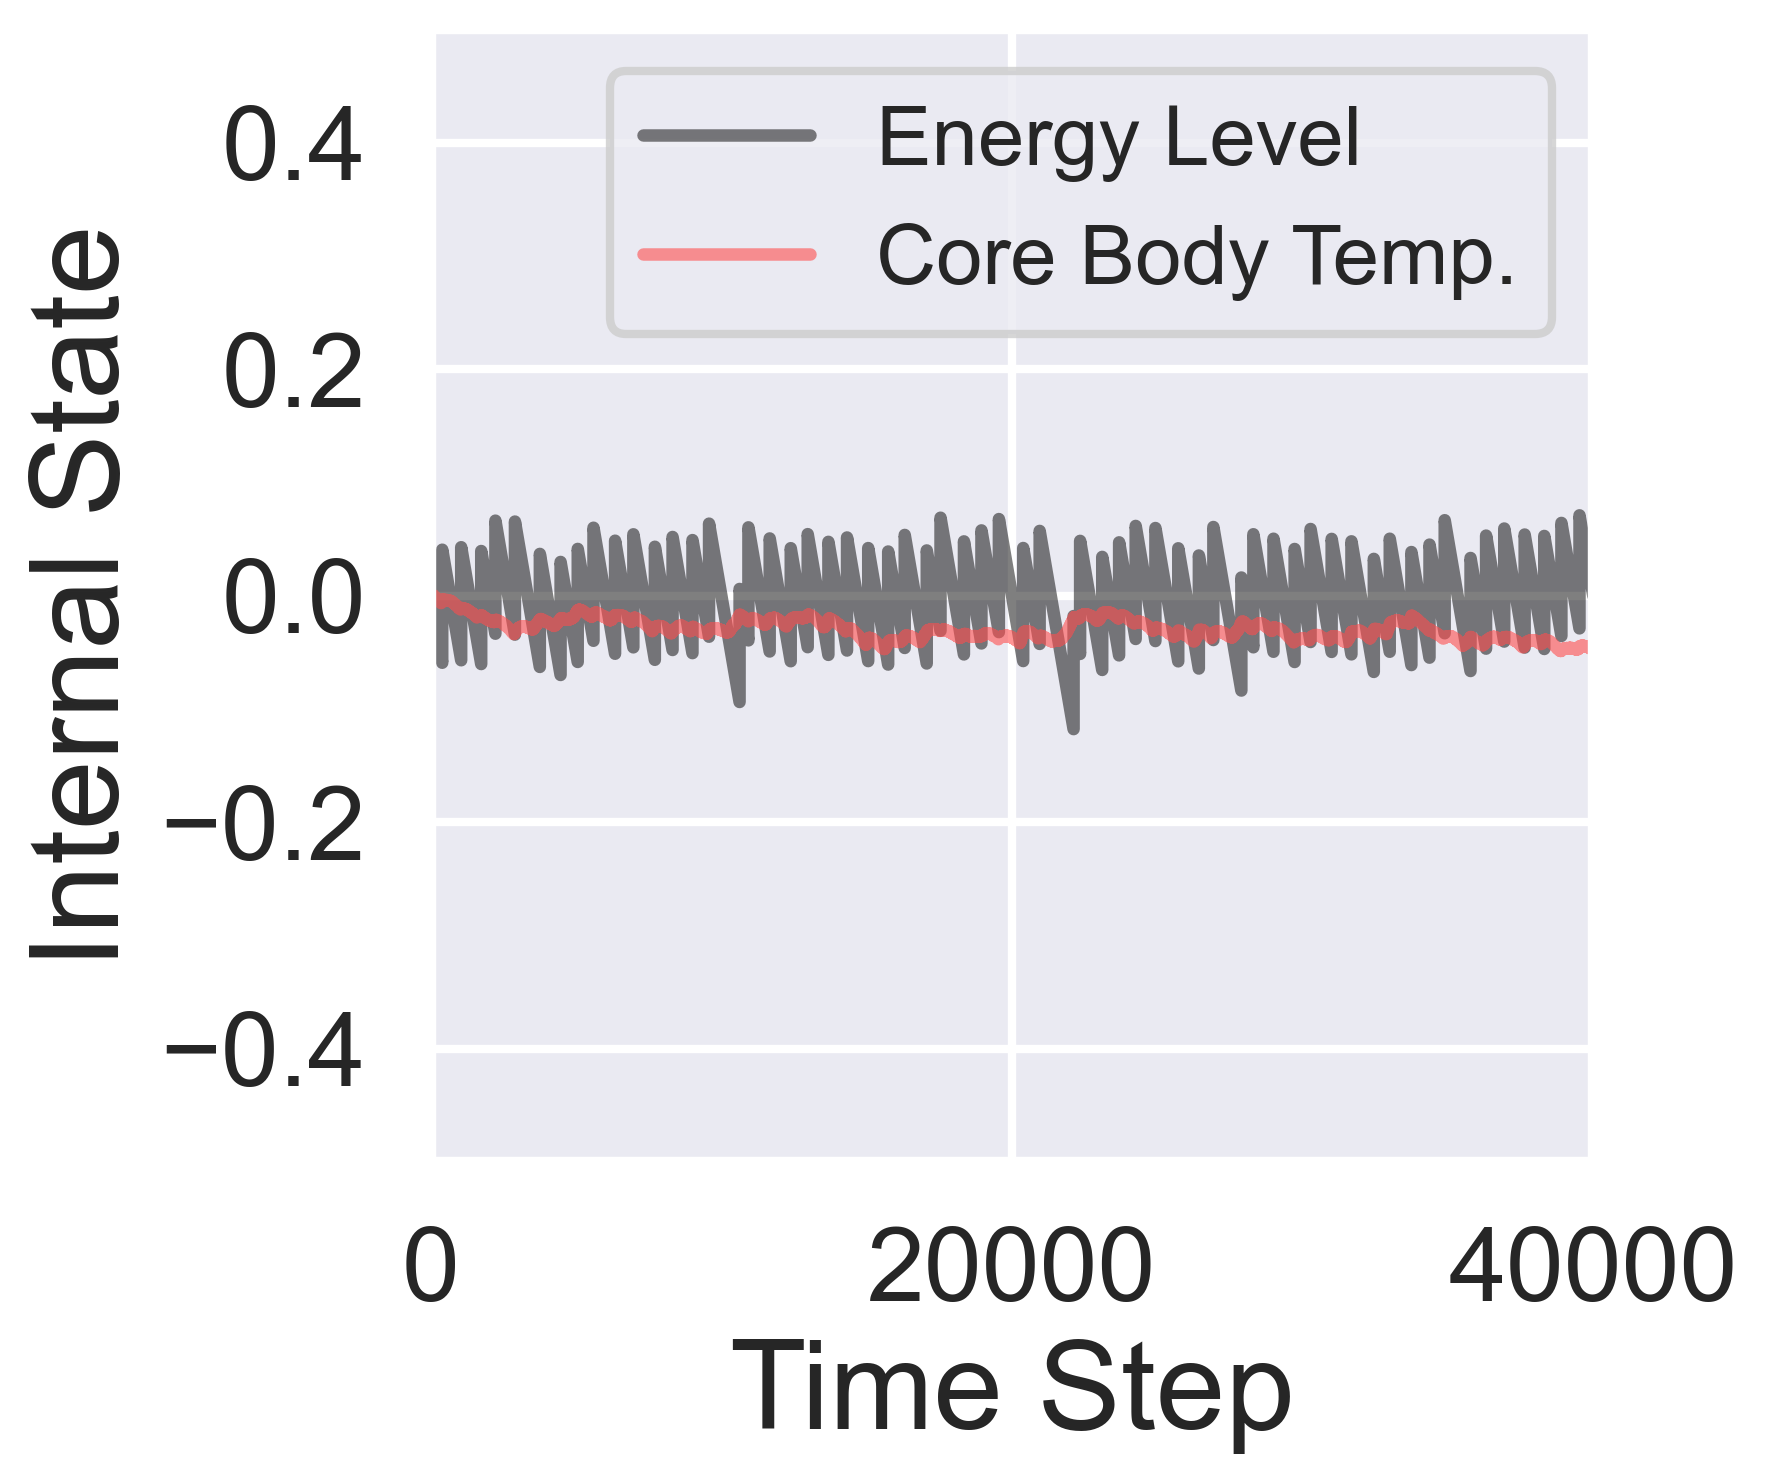

In [13]:
fig = plt.figure(figsize=(5, 5), dpi=300)

time_tick = np.arange(len(energy_hist))

start = 0 # 40000
end = MAX_DATA # 80000

plt.plot(time_tick[0:(end-start)], energy_hist[start:end], color=(0,0,0,0.5))
plt.plot(time_tick[0:(end-start)], np.array(temp_hist[start:end]), color=(1,.3,.3,0.6))
# plt.tick_params(left = False, right = False , labelbottom = False, bottom = False)
plt.xlim([start, end])
plt.ylim([-0.3, 0.3])

plt.ylabel("Internal State", fontsize=30)
plt.xlabel("Time Step", fontsize=30)
plt.ylim([-0.5, 0.5])
plt.xlim([0, 40000])
#plt.xticks([10000 * i for i in range(5)])
plt.tick_params(labelsize=25)

plt.legend(["Energy Level", "Core Body Temp."], prop={'size': 20})

plt.savefig("thermal40000.png", bbox_inches='tight')

(-0.2, 0.2)

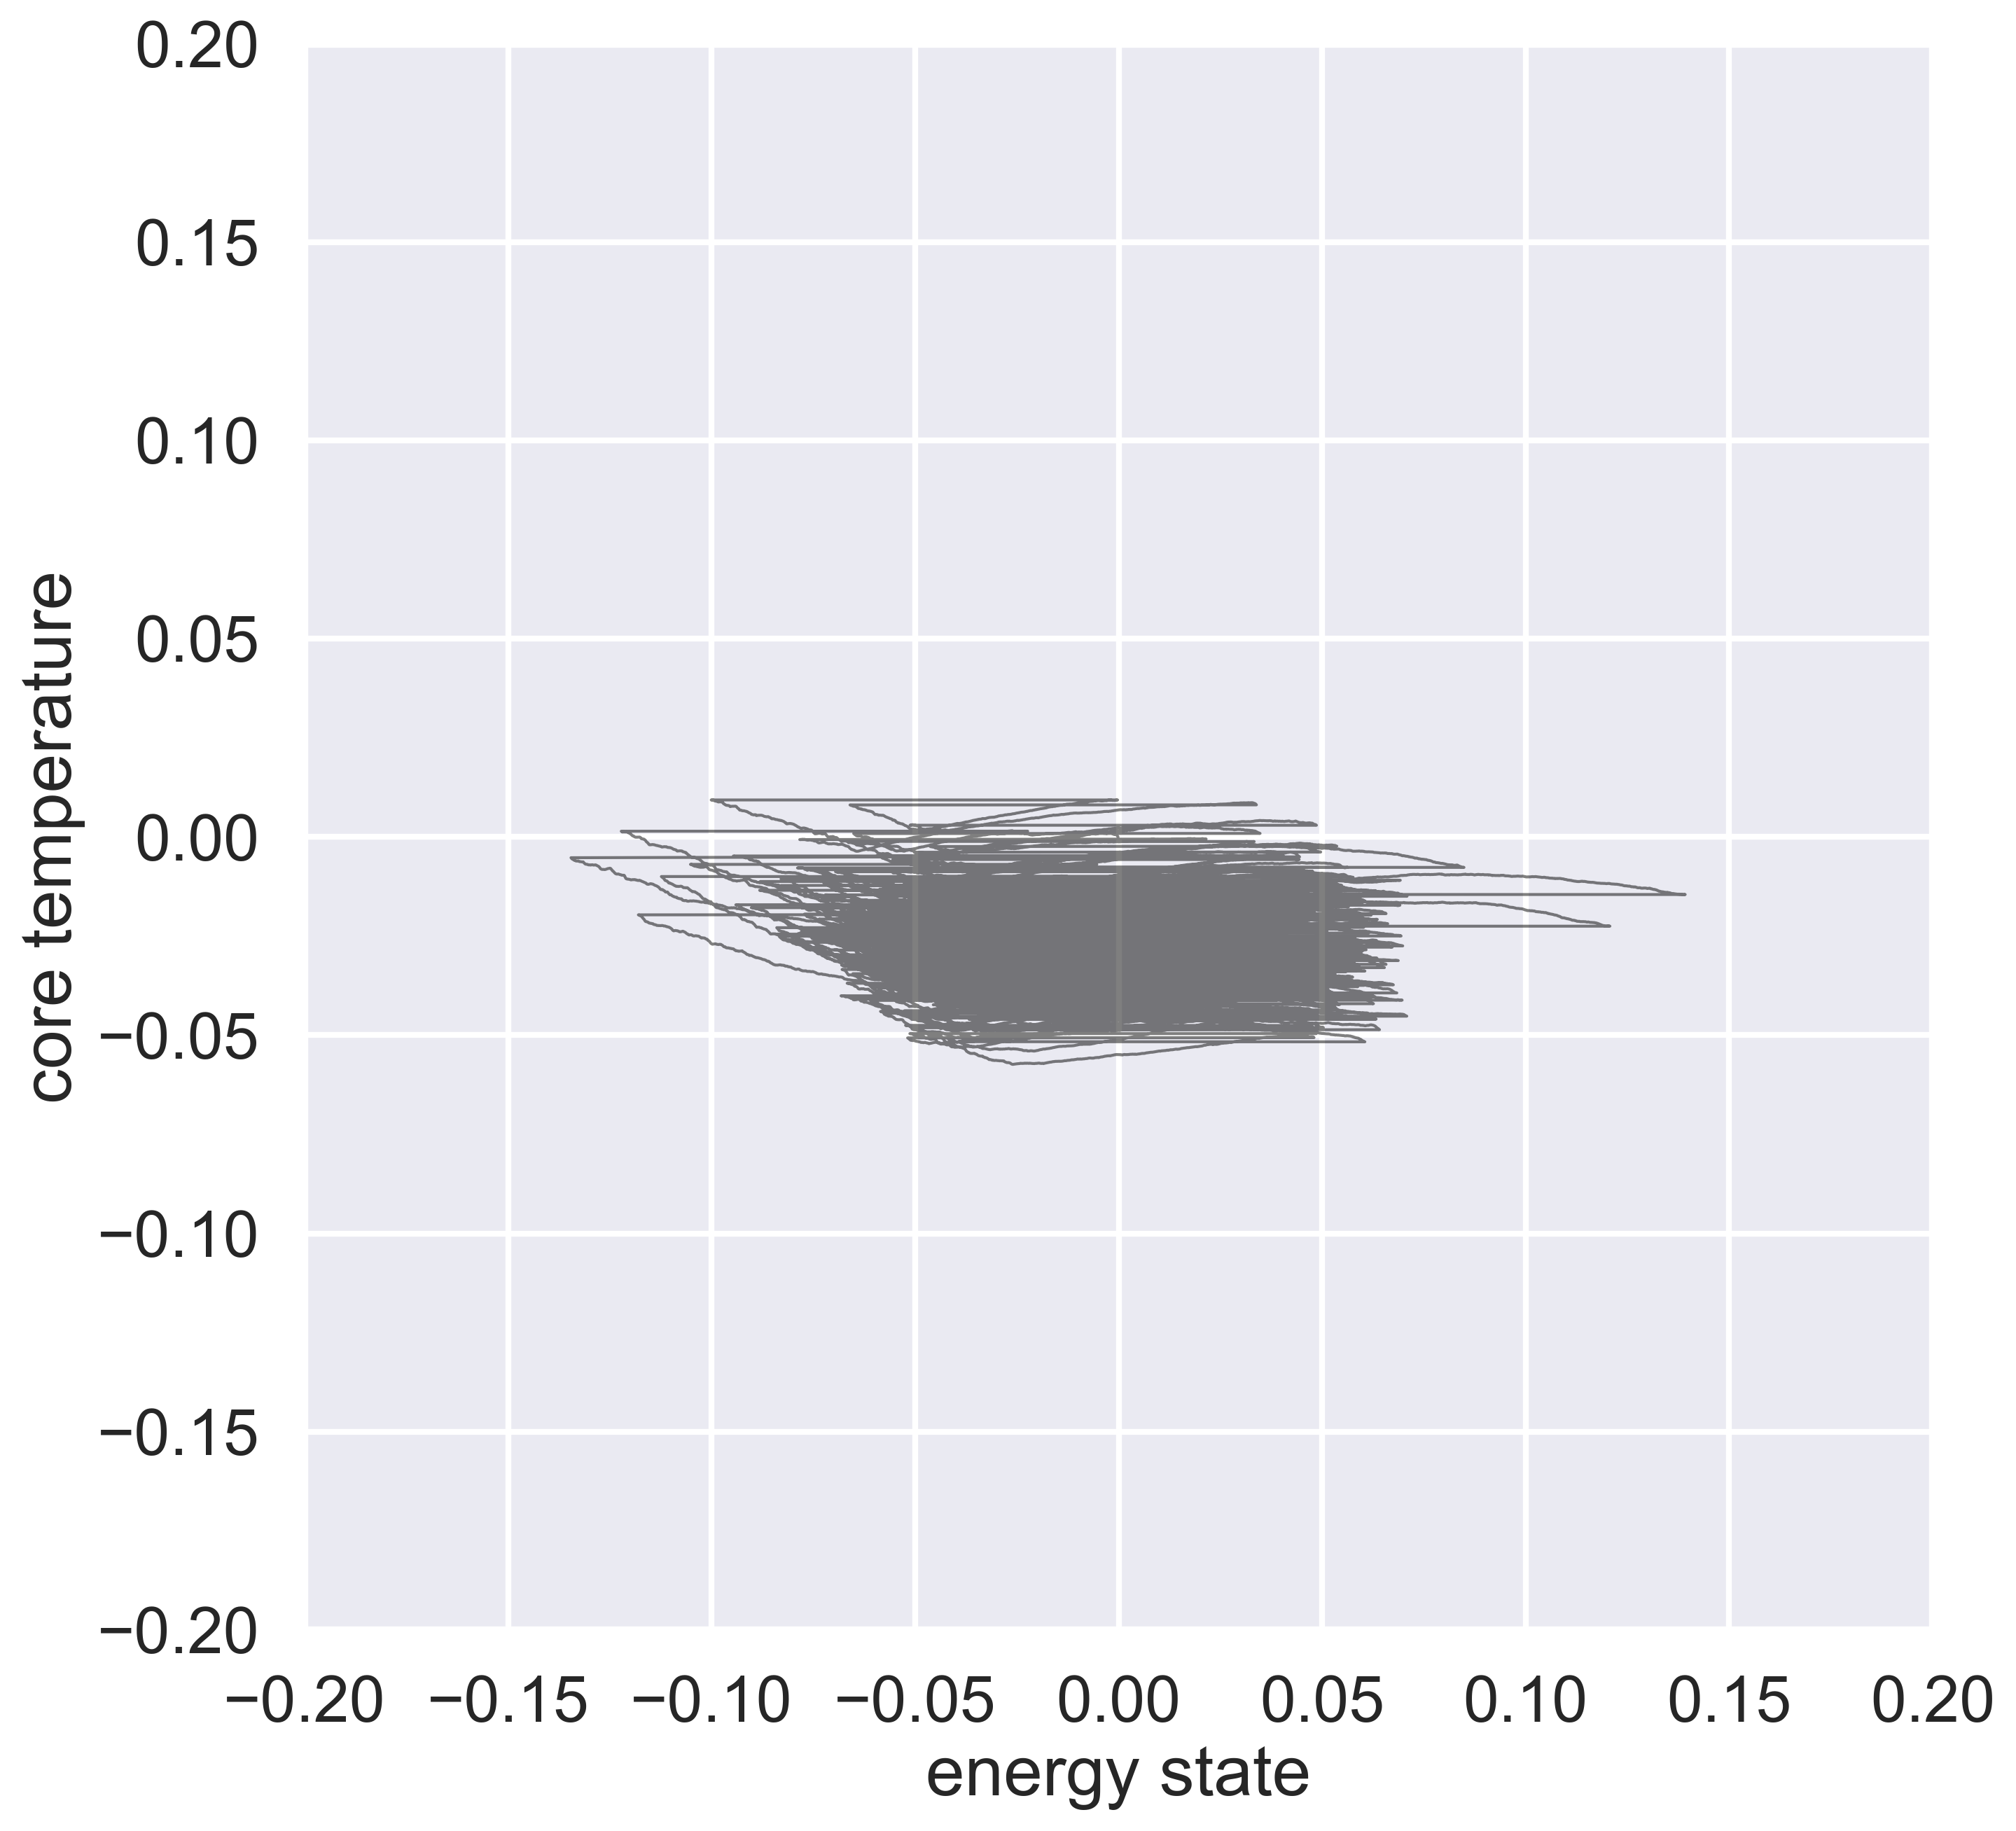

In [10]:
fig = plt.figure(figsize=(10, 10), dpi=300)

time_tick = np.arange(len(energy_hist))

start = 0
end = MAX_DATA

plt.ylabel("core temperature")
plt.xlabel("energy state")
plt.plot(energy_hist[start:end], np.array(temp_hist[start:end]), color=(0,0,0,0.5), linewidth=1)
# plt.tick_params(left = False, right = False , labelbottom = False, bottom = False)

# currentAxis = plt.gca()
# currentAxis.add_patch(Rectangle((-1, -1), 2, 2,alpha=0.1))

plt.xlim([-.2, .2])
plt.ylim([-.2, .2])

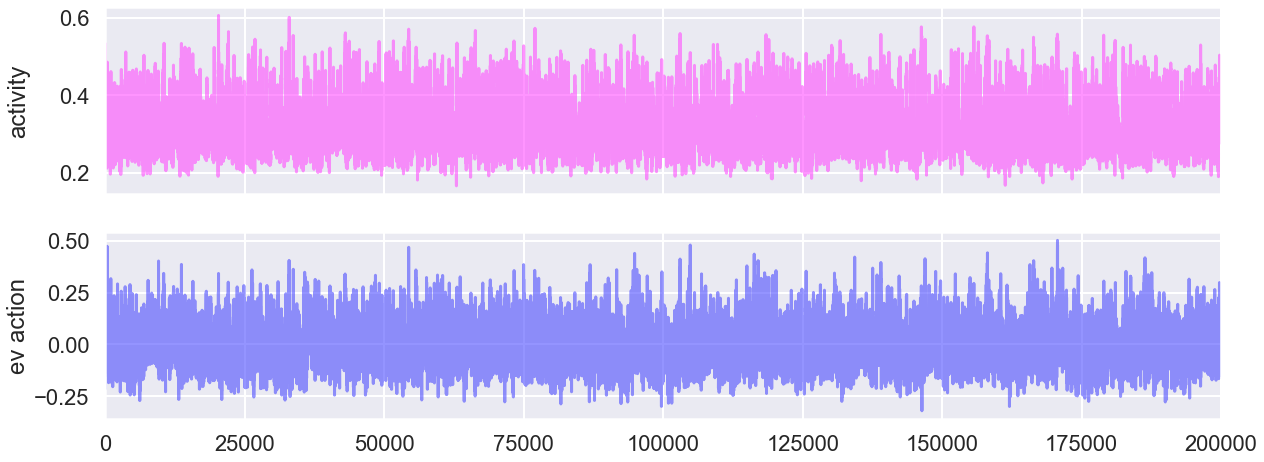

In [11]:
fig = plt.figure(figsize=(20, 20))

time_tick = np.arange(len(energy_hist))

start = 0
end = MAX_DATA

plt.subplot(514)
plt.ylabel("activity")
plt.plot(time_tick[start:end], np.array(activity_hist[start:end]), color=(1,0.3,1,0.6))
plt.tick_params(left = False, right = False , labelbottom = False, bottom = False)
plt.xlim([start, end])

plt.subplot(515)
plt.ylabel("ev action")
plt.plot(time_tick[start:end], np.array(ev_action_hist[start:end]), color=(0.3,0.3,1,0.6))
plt.tick_params(left = False, right = False)
plt.xlim([start, end])
# plt.ylim([-0.6, 0.6])

fig.align_labels()

(300, 401)
num trajectory:  300


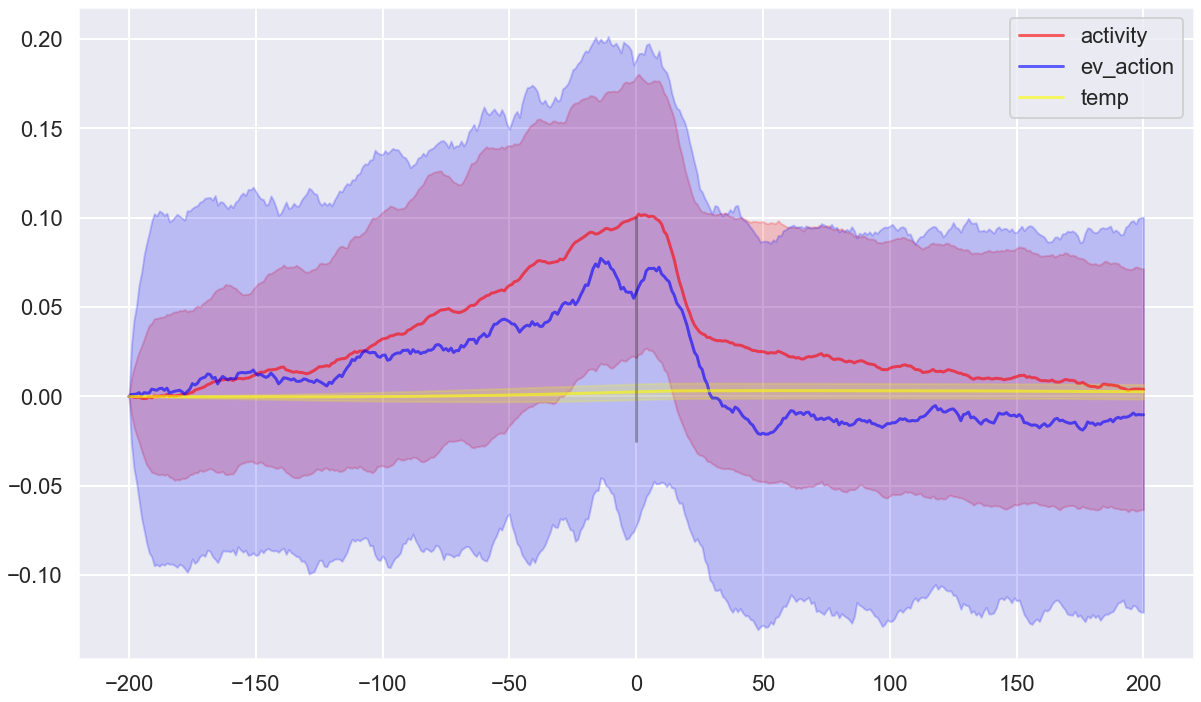

In [12]:
window_size = 200

a = np.array(food_eaten_t) > window_size
b = (np.array(food_eaten_t) + window_size) < MAX_DATA
condition = a & b

temp = np.zeros((sum(condition), window_size * 2 + 1))
activity = np.zeros((sum(condition), window_size * 2 + 1))
eva = np.zeros((sum(condition), window_size * 2 + 1))

n = 0
for spike_t in food_eaten_t:
    if spike_t > window_size and spike_t + window_size < MAX_DATA:
        for t in np.arange(-window_size, window_size + 1):
            activity[n, t + window_size] = activity_hist[spike_t + t]  - activity_hist[spike_t - window_size] 
            eva[n, t + window_size] = ev_action_hist[spike_t + t] - ev_action_hist[spike_t - window_size]
            temp[n, t + window_size] = temp_hist[spike_t + t] - temp_hist[spike_t - window_size]
        n += 1

average_activity = activity.mean(axis=0)
std_activity = activity.std(axis=0)

average_eva = eva.mean(axis=0)
std_eva = eva.std(axis=0)

average_temp = temp.mean(axis=0)
std_temp = temp.std(axis=0)

print(activity.shape)
print("num trajectory: ", n)

fig = plt.figure(figsize=(20, 12))
x_tick = np.arange(-window_size, window_size + 1)

plt.plot(x_tick, average_activity, color=(1, 0, 0, 0.6))
plt.fill_between(x_tick,
                 average_activity + std_activity,
                 average_activity - std_activity,
                 color=(1, 0, 0, 0.2))

plt.plot(x_tick, average_eva, color=(0, 0, 1, 0.6))
plt.fill_between(x_tick,
                 average_eva + std_eva,
                 average_eva - std_eva,
                 color=(0, 0, 1, 0.2))

plt.plot(x_tick, average_temp, color=(1, 1, 0, 0.6))
plt.fill_between(x_tick,
                 average_temp + std_temp,
                 average_temp - std_temp,
                 color=(1, 1, 0, 0.2))

plt.plot([0, 0], [-0.025, 0.1], color=(0, 0, 0, 0.3))
plt.legend(["activity", "ev_action", "temp"])
plt.show()

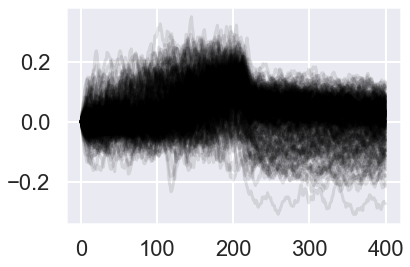

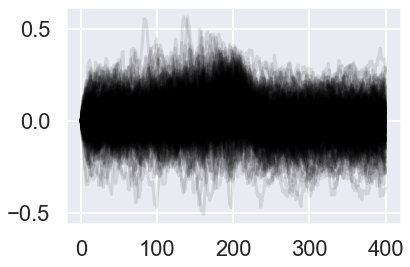

In [13]:
plt.plot(activity.transpose(), color=(0, 0, 0, 0.1));
plt.show()

plt.plot(eva.transpose(), color=(0, 0, 0, 0.1));

(300, 401)
num trajectory:  300


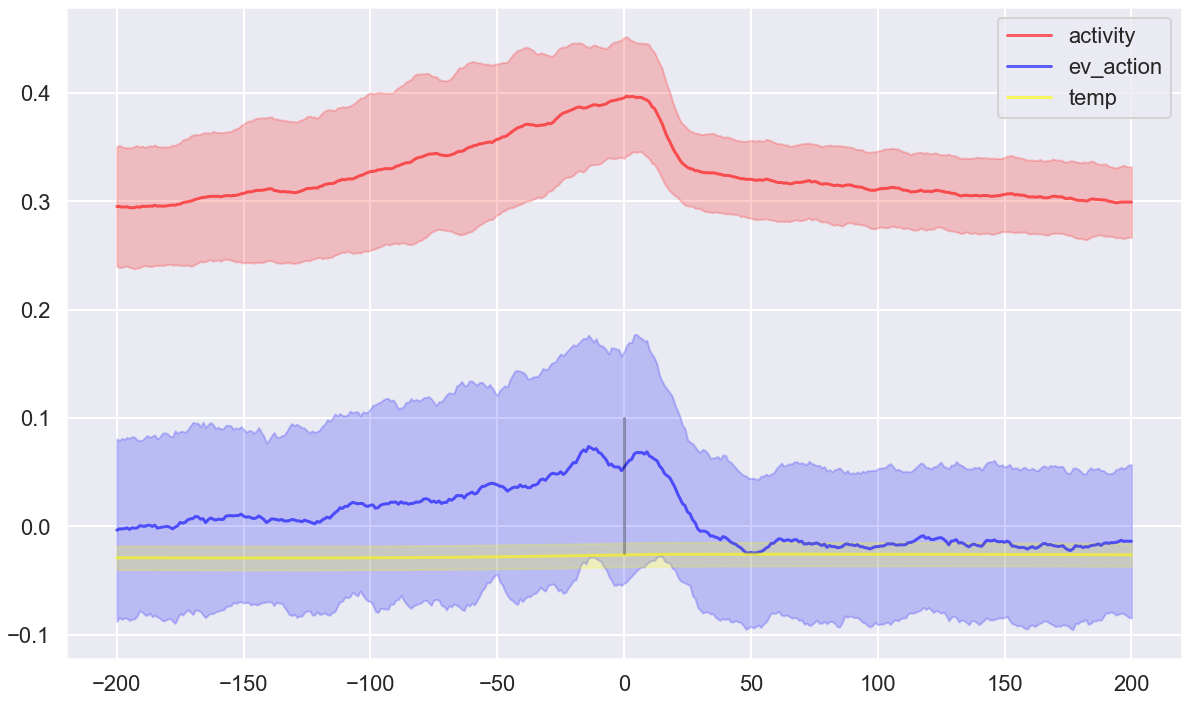

In [14]:
window_size = 200

a = np.array(food_eaten_t) > window_size
b = (np.array(food_eaten_t) + window_size) < MAX_DATA
condition = a & b

temp = np.zeros((sum(condition), window_size * 2 + 1))
activity = np.zeros((sum(condition), window_size * 2 + 1))
eva = np.zeros((sum(condition), window_size * 2 + 1))

n = 0
for spike_t in food_eaten_t:
    if spike_t > window_size and spike_t + window_size < MAX_DATA:
        for t in np.arange(-window_size, window_size + 1):
            activity[n, t + window_size] = activity_hist[spike_t + t] 
            eva[n, t + window_size] = ev_action_hist[spike_t + t]
            temp[n, t + window_size] = temp_hist[spike_t + t] 
        n += 1

average_activity = activity.mean(axis=0)
std_activity = activity.std(axis=0)

average_eva = eva.mean(axis=0)
std_eva = eva.std(axis=0)

average_temp = temp.mean(axis=0)
std_temp = temp.std(axis=0)

print(activity.shape)
print("num trajectory: ", n)

fig = plt.figure(figsize=(20, 12))
x_tick = np.arange(-window_size, window_size + 1)

plt.plot(x_tick, average_activity, color=(1, 0, 0, 0.6))
plt.fill_between(x_tick,
                 average_activity + std_activity,
                 average_activity - std_activity,
                 color=(1, 0, 0, 0.2))

plt.plot(x_tick, average_eva, color=(0, 0, 1, 0.6))
plt.fill_between(x_tick,
                 average_eva + std_eva,
                 average_eva - std_eva,
                 color=(0, 0, 1, 0.2))

plt.plot(x_tick, average_temp, color=(1, 1, 0, 0.6))
plt.fill_between(x_tick,
                 average_temp + std_temp,
                 average_temp - std_temp,
                 color=(1, 1, 0, 0.2))

plt.plot([0, 0], [-0.025, 0.1], color=(0, 0, 0, 0.3))
plt.legend(["activity", "ev_action", "temp"])
plt.show()

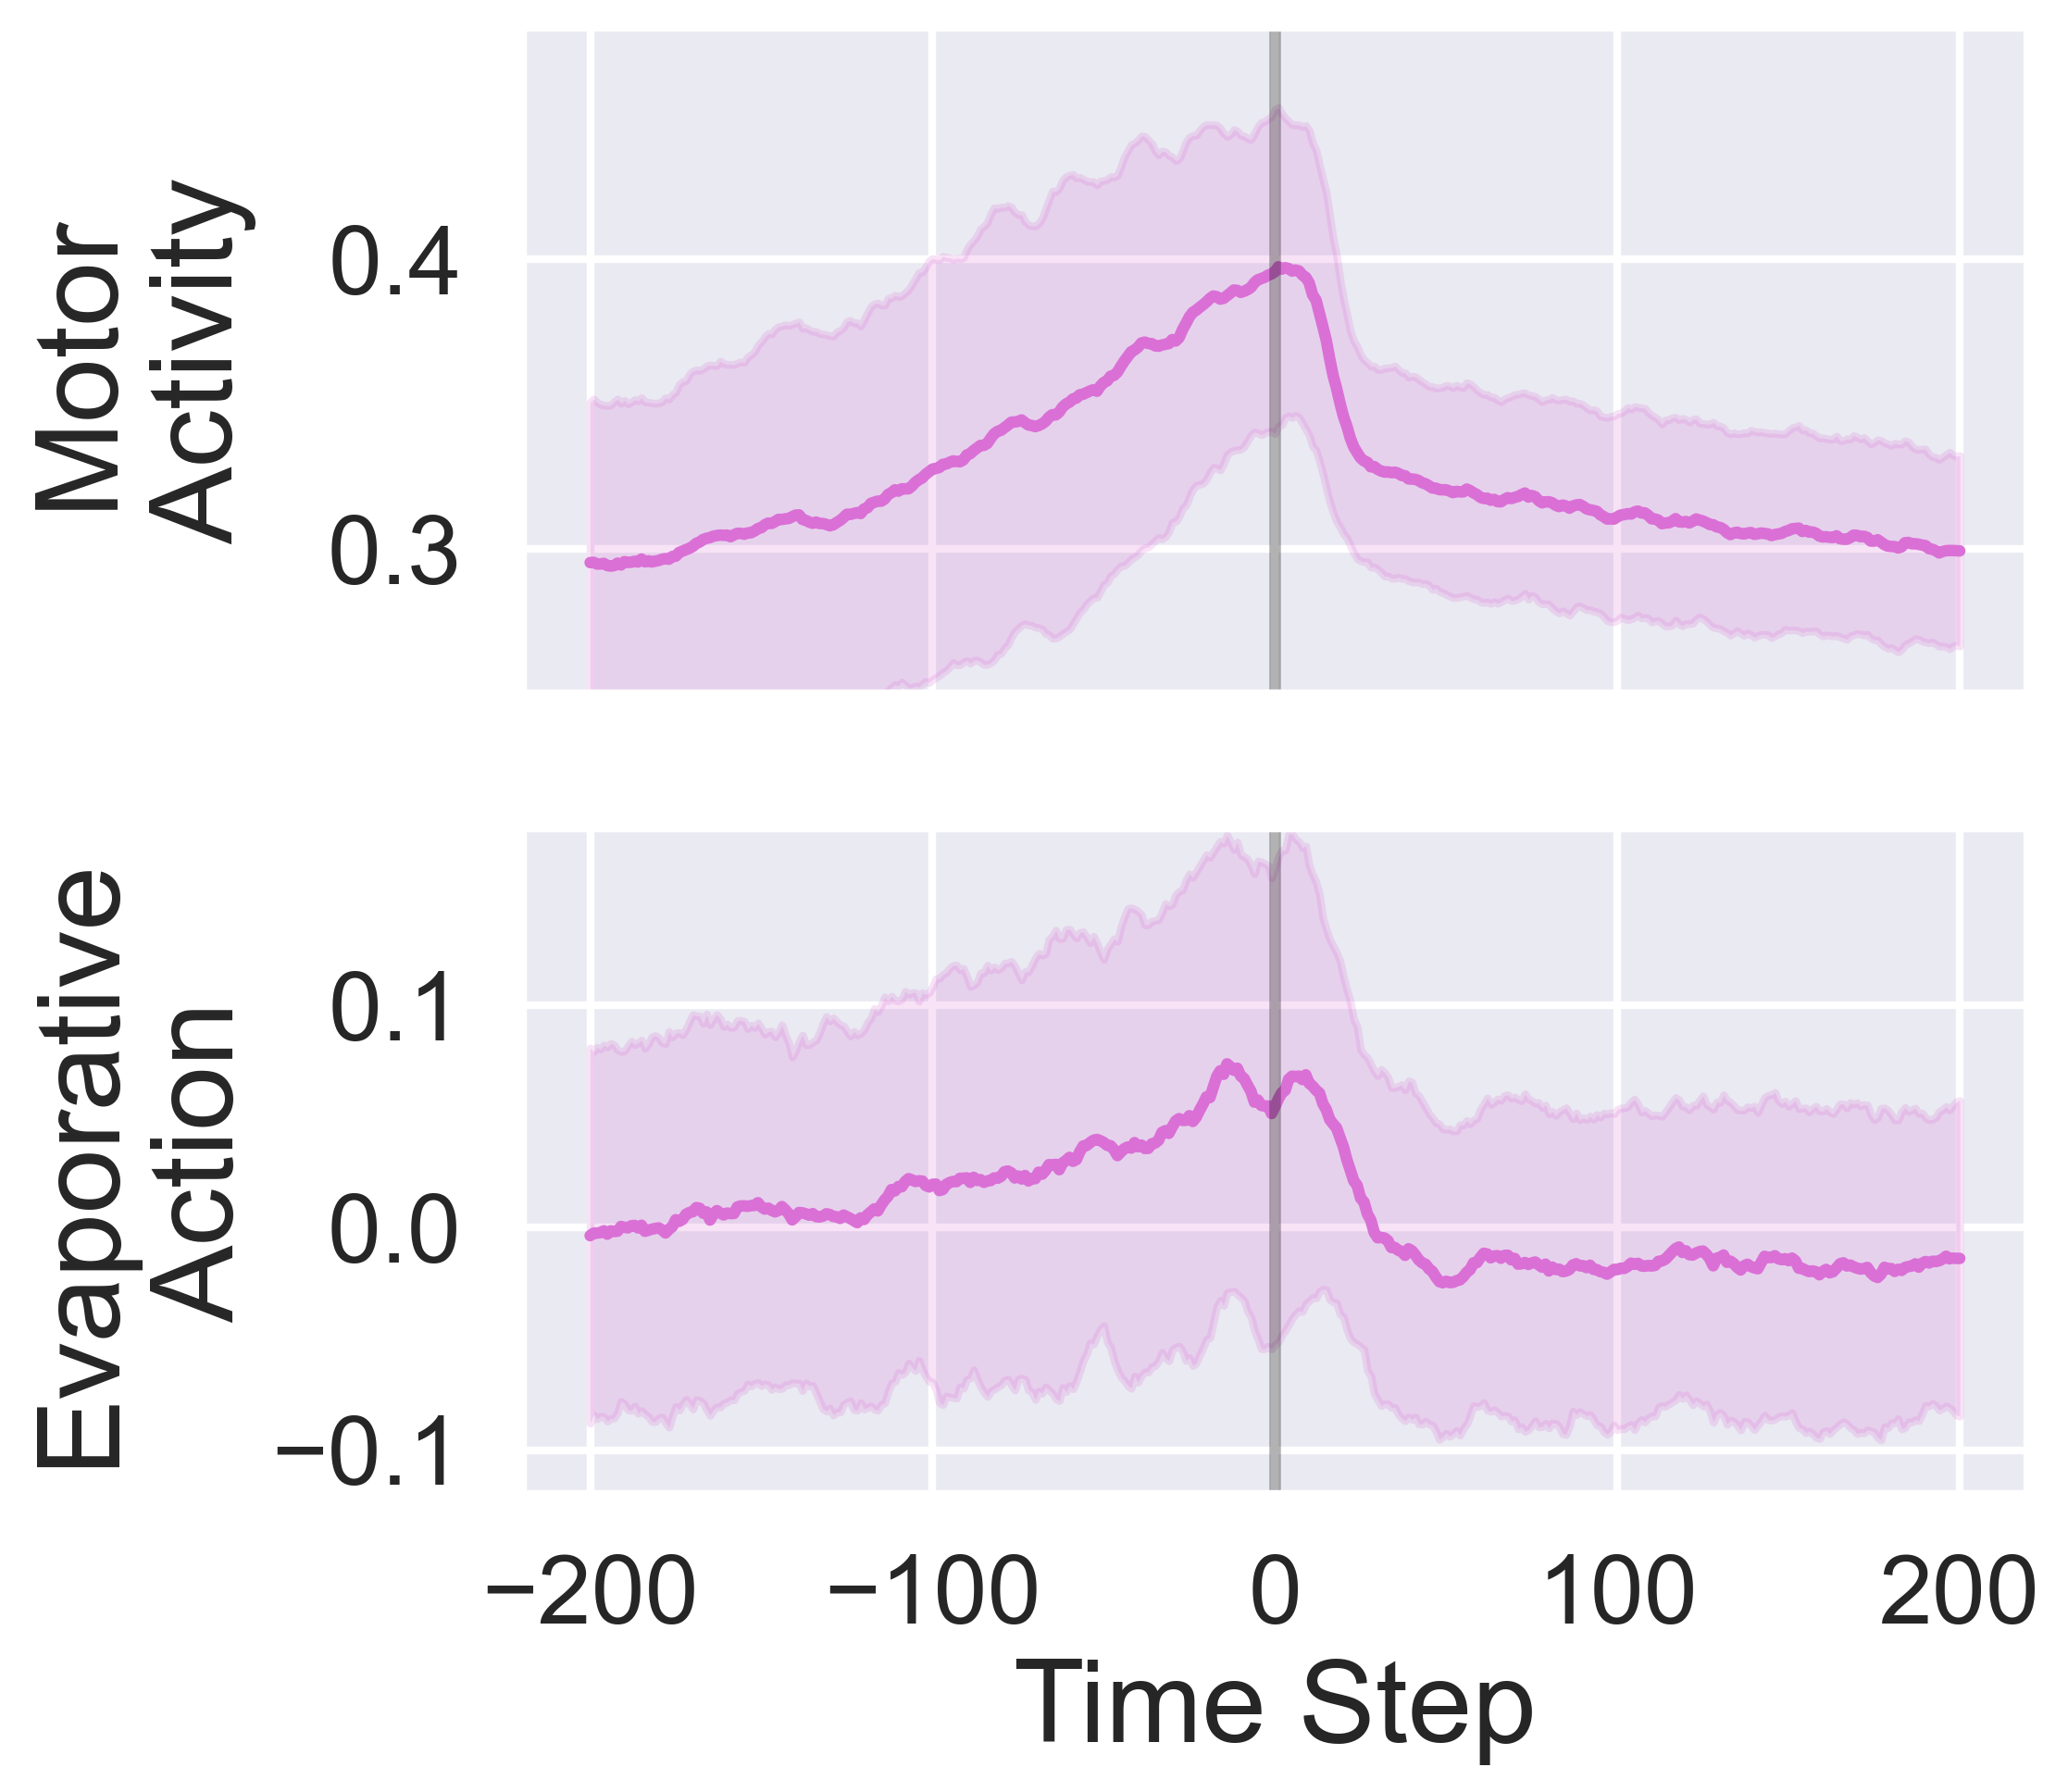

In [15]:
window_size = 200

fig = plt.figure(figsize=(7, 7), dpi=300)
x_tick = np.arange(-window_size, window_size + 1)

plt.subplot(211)
plt.plot(x_tick, average_activity, color="orchid")
plt.fill_between(x_tick,
                 average_activity + std_activity,
                 average_activity - std_activity,
                 color="orchid", alpha=0.2)
plt.plot([0, 0], [0.2, 0.5], color=(0, 0, 0, 0.3))

plt.ylabel("Motor\nActivity", fontsize=30)
plt.tick_params(left = False, right = False , labelbottom = False, bottom = False)
plt.tick_params(labelsize=25)
plt.ylim([0.25, 0.48])
plt.yticks([0.3, 0.4])

plt.subplot(212)
plt.plot(x_tick, average_eva, color="orchid")
plt.fill_between(x_tick,
                 average_eva + std_eva,
                 average_eva - std_eva,
                 color="orchid", alpha=0.2)
plt.plot([0, 0], [-0.15, 0.2], color=(0, 0, 0, 0.3))

plt.ylabel("Evaporative\nAction", fontsize=30)
plt.xlabel("Time Step", fontsize=30)
plt.tick_params(labelsize=25)
plt.ylim([-0.12, 0.18])
plt.yticks([-0.1, 0, 0.1])

# plt.subplot(313)
# plt.plot(x_tick, average_temp, color=(0, 0.5, 0, 0.8))
# plt.fill_between(x_tick,
#                  average_temp + std_temp,
#                  average_temp - std_temp,
#                  color=(0, 0.5, 0, 0.2))
# #plt.plot([0, 0], [-0.05, 0.05], color=(0, 0, 0, 0.3))
# plt.ylabel("body temp")

fig.align_labels()

plt.savefig("food_capture_dependent_activity.png", bbox_inches='tight')

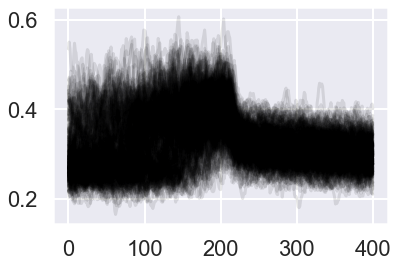

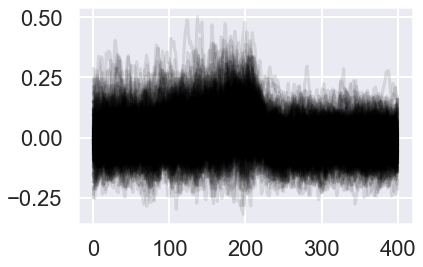

In [16]:
plt.plot(activity.transpose(), color=(0, 0, 0, 0.1));
plt.show()

plt.plot(eva.transpose(), color=(0, 0, 0, 0.1));

# Statistical Testing of Activation dependent on the temperature perception clamping

In [20]:
N_TRIAL = 10
WINDOW_AVE = 1
MAX_DATA = 5000

In [ ]:
average_activity_n = []

energy_hist_n = np.zeros((N_TRIAL, MAX_DATA))
temp_hist_n = np.zeros((N_TRIAL, MAX_DATA))
activity_hist_n = np.zeros((N_TRIAL, MAX_DATA))
ev_action_hist_n = np.zeros((N_TRIAL, MAX_DATA))

    
for n in range(N_TRIAL):
    env = get_env(seed=n, n_energy=6)

#     energy_hist = sliceable_deque(maxlen=MAX_DATA)
#     temp_hist = sliceable_deque(maxlen=MAX_DATA)
#     activity_hist = sliceable_deque(maxlen=MAX_DATA)
#     ev_action_hist = sliceable_deque(maxlen=MAX_DATA)

    with agent.eval_mode():    
        # Normal
        energy_record = deque(maxlen=WINDOW_AVE)
        temp_record = deque(maxlen=WINDOW_AVE)
        activity_record = deque(maxlen=WINDOW_AVE)
        ev_action_record = deque(maxlen=WINDOW_AVE)

        obs = env.reset()

        for i in tqdm.tqdm(range(MAX_DATA)):
            action = agent.act(obs)

            obs, r, done, _ = env.step(action)

            energy_now, temp_now = env.get_interoception()
            motor_action = 2 * (action[:-1] - 0.5)
            activity = np.sqrt(sum(np.square(motor_action))/motor_action.size)
            evaporative_action = 2 * (action[-1] - 0.5)

            energy_record.append(energy_now)
            temp_record.append(temp_now)
            activity_record.append(activity)
            ev_action_record.append(evaporative_action)

            energy_hist_n[n, i] = energy_now
            temp_hist_n[n, i] = temp_now
            activity_hist_n[n, i] = np.mean(activity_record)
            ev_action_hist_n[n, i] = np.mean(ev_action_record)

            if done:
                break
    
    average_activity_n.append(np.mean(activity_hist))

env.close()

In [ ]:
TEMP_H = 0.2

average_activity_h = []

energy_hist_h = np.zeros((N_TRIAL, MAX_DATA))
temp_hist_h = np.zeros((N_TRIAL, MAX_DATA))
activity_hist_h = np.zeros((N_TRIAL, MAX_DATA))
ev_action_hist_h = np.zeros((N_TRIAL, MAX_DATA))


for n in range(N_TRIAL):
    env = get_env(seed=n+N_TRIAL, n_energy=6)

#     energy_hist_h = sliceable_deque(maxlen=MAX_DATA)
#     temp_hist_h = sliceable_deque(maxlen=MAX_DATA)
#     activity_hist_h = sliceable_deque(maxlen=MAX_DATA)
#     ev_action_hist_h = sliceable_deque(maxlen=MAX_DATA)

    with agent.eval_mode():                
        # High Temp
        energy_record_h = deque(maxlen=WINDOW_AVE)
        temp_record_h = deque(maxlen=WINDOW_AVE)
        activity_record_h = deque(maxlen=WINDOW_AVE)
        ev_action_record_h = deque(maxlen=WINDOW_AVE)

        obs = env.reset()
        obs[-1] = TEMP_H

        for i in tqdm.tqdm(range(MAX_DATA)):
            action = agent.act(obs)

            obs, _, done, _ = env.step(action)
            obs[-1] = TEMP_H

            energy_now, temp_now = env.get_interoception()
            motor_action = 2 * (action[:-1] - 0.5)
            activity = np.sqrt(sum(np.square(motor_action))/motor_action.size)
            evaporative_action = 2 * (action[-1] - 0.5)

            energy_record_h.append(energy_now)
            temp_record_h.append(temp_now)
            activity_record_h.append(activity)
            ev_action_record_h.append(evaporative_action)

            energy_hist_h[n, i] = energy_now
            temp_hist_h[n, i] = temp_now
            activity_hist_h[n, i] = np.mean(activity_record_h)
            ev_action_hist_h[n, i] = np.mean(ev_action_record_h)

            if done:
                break

    average_activity_h.append(np.mean(activity_hist_h))

env.close()

In [ ]:
TEMP_L = -0.2

average_activity_l = []

energy_hist_l = np.zeros((N_TRIAL, MAX_DATA))
temp_hist_l = np.zeros((N_TRIAL, MAX_DATA))
activity_hist_l = np.zeros((N_TRIAL, MAX_DATA))
ev_action_hist_l = np.zeros((N_TRIAL, MAX_DATA))


for n in range(N_TRIAL):
    env = get_env(seed=n+2*N_TRIAL, n_energy=6)

#     energy_hist_l = sliceable_deque(maxlen=MAX_DATA)
#     temp_hist_l = sliceable_deque(maxlen=MAX_DATA)
#     activity_hist_l = sliceable_deque(maxlen=MAX_DATA)
#     ev_action_hist_l = sliceable_deque(maxlen=MAX_DATA)

    with agent.eval_mode():    
        # Low Temp
        energy_record_l = deque(maxlen=WINDOW_AVE)
        temp_record_l = deque(maxlen=WINDOW_AVE)
        activity_record_l = deque(maxlen=WINDOW_AVE)
        ev_action_record_l = deque(maxlen=WINDOW_AVE)

        obs = env.reset() 
        obs[-1] = TEMP_L

        for i in tqdm.tqdm(range(MAX_DATA)):
            action = agent.act(obs)

            obs, r, done, _ = env.step(action)
            obs[-1] = TEMP_L

            energy_now, temp_now = env.get_interoception()
            motor_action = 2 * (action[:-1] - 0.5)
            activity = np.sqrt(sum(np.square(motor_action))/motor_action.size)
            evaporative_action = 2 * (action[-1] - 0.5)

            energy_record_l.append(energy_now)
            temp_record_l.append(temp_now)
            activity_record_l.append(activity)
            ev_action_record_l.append(evaporative_action)

            energy_hist_l[n, i] = energy_now
            temp_hist_l[n, i] = temp_now
            activity_hist_l[n, i] = np.mean(activity_record_l)
            ev_action_hist_l[n, i] = np.mean(ev_action_record_l)

            if done:
                break
                
    average_activity_l.append(np.mean(activity_hist_l))

env.close()

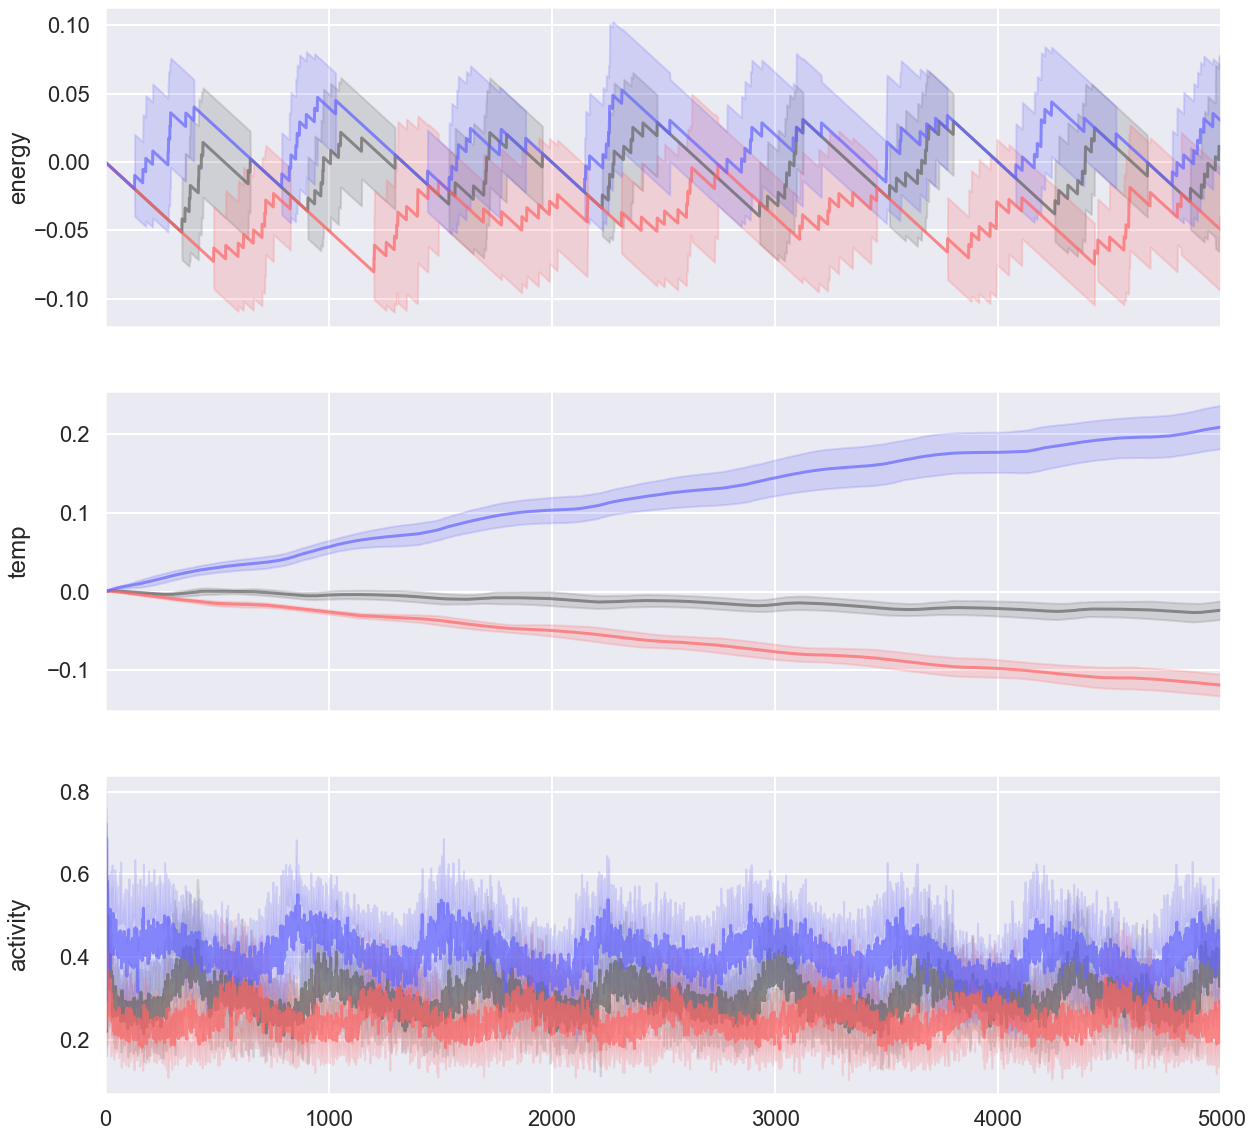

In [15]:
# np.save("time_tick.npy", time_tick)

# np.save("energy_hist_n.npy", energy_hist_n)
# np.save("temp_hist_n.npy", temp_hist_n)
# np.save("activity_hist_n.npy", activity_hist_n)
# np.save("ev_action_hist_n.npy", ev_action_hist_n)

# np.save("energy_hist_h.npy", energy_hist_h)
# np.save("temp_hist_h.npy", temp_hist_h)
# np.save("activity_hist_h.npy", activity_hist_h)
# np.save("ev_action_hist_h.npy", ev_action_hist_h)

# np.save("energy_hist_l.npy", energy_hist_l)
# np.save("temp_hist_l.npy", temp_hist_l)
# np.save("activity_hist_l.npy", activity_hist_l)
# np.save("ev_action_hist_l.npy", ev_action_hist_l)


energy_hist_n = np.load("energy_hist_n.npy")
temp_hist_n = np.load("temp_hist_n.npy")
activity_hist_n = np.load("activity_hist_n.npy")
ev_action_hist_n = np.load("ev_action_hist_n.npy")

energy_hist_h = np.load("energy_hist_h.npy")
temp_hist_h = np.load("temp_hist_h.npy")
activity_hist_h = np.load("activity_hist_h.npy")
ev_action_hist_h = np.load("ev_action_hist_h.npy")

energy_hist_l = np.load("energy_hist_l.npy")
temp_hist_l = np.load("temp_hist_l.npy")
activity_hist_l = np.load("activity_hist_l.npy")
ev_action_hist_l = np.load("ev_action_hist_l.npy")

average_activity_n = np.mean(activity_hist_n, axis=1)
average_activity_h = np.mean(activity_hist_h, axis=1)
average_activity_l = np.mean(activity_hist_l, axis=1)



# Plot
fig = plt.figure(figsize=(20, 20))
plt.legend(["energy", "core temperature", "activity", "ev action"])

time_tick = np.arange(len(energy_hist_n.mean(axis=0)))

start = 0
end = len(time_tick)

base = 0.4
col = (base, base, base, 0.7)
col_h = (1, base, base, 0.7) 
col_l = (base, base, 1, 0.7)

colf = (base, base, base, 0.2)
col_hf = (1, base, base, 0.2) 
col_lf = (base, base, 1, 0.2)

plt.subplot(311)
plt.ylabel("energy")
plt.plot(time_tick[start:end], energy_hist_n.mean(axis=0)[start:end], color=col)
plt.fill_between(time_tick[start:end],
                 energy_hist_n.mean(axis=0)[start:end] + energy_hist_n.std(axis=0)[start:end],
                 energy_hist_n.mean(axis=0)[start:end] - energy_hist_n.std(axis=0)[start:end],
                 color = colf)

plt.plot(time_tick[start:end], energy_hist_h.mean(axis=0)[start:end], color=col_h)
plt.fill_between(time_tick[start:end],
                 energy_hist_h.mean(axis=0)[start:end] + energy_hist_h.std(axis=0)[start:end],
                 energy_hist_h.mean(axis=0)[start:end] - energy_hist_h.std(axis=0)[start:end],
                 color = col_hf)

plt.plot(time_tick[start:end], energy_hist_l.mean(axis=0)[start:end], color=col_l)
plt.fill_between(time_tick[start:end],
                 energy_hist_l.mean(axis=0)[start:end] + energy_hist_l.std(axis=0)[start:end],
                 energy_hist_l.mean(axis=0)[start:end] - energy_hist_l.std(axis=0)[start:end],
                 color = col_lf)

plt.tick_params(left = False, right = False , labelbottom = False, bottom = False)
plt.xlim([start, end])

plt.subplot(312)
plt.ylabel("temp")
plt.plot(time_tick[start:end], np.array(temp_hist_n.mean(axis=0)[start:end]), color=col)
plt.fill_between(time_tick[start:end],
                 np.array(temp_hist_n.mean(axis=0)[start:end]) + np.array(temp_hist_n.std(axis=0)[start:end]),
                 np.array(temp_hist_n.mean(axis=0)[start:end]) - np.array(temp_hist_n.std(axis=0)[start:end]),
                 color = colf)

plt.plot(time_tick[start:end], np.array(temp_hist_h.mean(axis=0)[start:end]), color=col_h)
plt.fill_between(time_tick[start:end],
                 np.array(temp_hist_h.mean(axis=0)[start:end]) + np.array(temp_hist_h.std(axis=0)[start:end]),
                 np.array(temp_hist_h.mean(axis=0)[start:end]) - np.array(temp_hist_h.std(axis=0)[start:end]),
                 color = col_hf)

plt.plot(time_tick[start:end], np.array(temp_hist_l.mean(axis=0)[start:end]), color=col_l)
plt.fill_between(time_tick[start:end],
                 np.array(temp_hist_l.mean(axis=0)[start:end]) + np.array(temp_hist_l.std(axis=0)[start:end]),
                 np.array(temp_hist_l.mean(axis=0)[start:end]) - np.array(temp_hist_l.std(axis=0)[start:end]),
                 color = col_lf)

plt.tick_params(left = False, right = False , labelbottom = False, bottom = False)
plt.xlim([start, end])

plt.subplot(313)
plt.ylabel("activity")
plt.plot(time_tick[start:end], np.array(activity_hist_n.mean(axis=0)[start:end]), color=col)
plt.fill_between(time_tick[start:end],
                 np.array(activity_hist_n.mean(axis=0)[start:end]) + np.array(activity_hist_n.std(axis=0)[start:end]),
                 np.array(activity_hist_n.mean(axis=0)[start:end]) - np.array(activity_hist_n.std(axis=0)[start:end]),
                 color = colf)

plt.plot(time_tick[start:end], np.array(activity_hist_h.mean(axis=0)[start:end]), color=col_h)
plt.fill_between(time_tick[start:end],
                 np.array(activity_hist_h.mean(axis=0)[start:end]) + np.array(activity_hist_h.std(axis=0)[start:end]),
                 np.array(activity_hist_h.mean(axis=0)[start:end]) - np.array(activity_hist_h.std(axis=0)[start:end]),
                 color = col_hf)

plt.plot(time_tick[start:end], np.array(activity_hist_l.mean(axis=0)[start:end]), color=col_l)
plt.fill_between(time_tick[start:end],
                 np.array(activity_hist_l.mean(axis=0)[start:end]) + np.array(activity_hist_l.std(axis=0)[start:end]),
                 np.array(activity_hist_l.mean(axis=0)[start:end]) - np.array(activity_hist_l.std(axis=0)[start:end]),
                 color = col_lf)

plt.tick_params(left = False, right = False)
plt.xlim([start, end])

"""
plt.subplot(414)
plt.ylabel("evaporative action")
plt.plot(time_tick[start:end], np.array(ev_action_hist[start:end]), color="k")
plt.plot(time_tick[start:end], np.array(ev_action_hist_h[start:end]), color="r")
plt.plot(time_tick[start:end], np.array(ev_action_hist_l[start:end]), color="b")
plt.tick_params(left = False, right = False)
plt.xlim([start, end])
# plt.ylim([-0.6, 0.6])
"""

fig.align_labels()

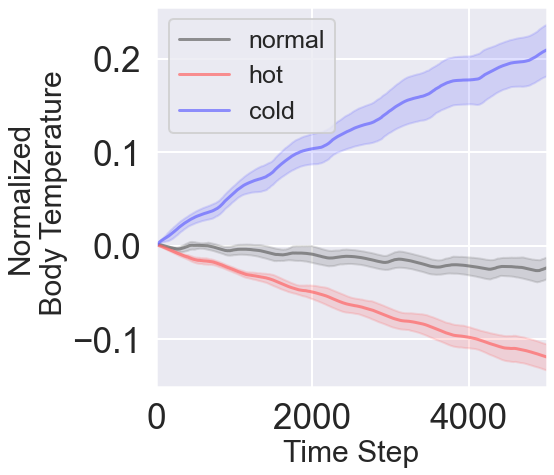

In [20]:
fig = plt.figure(figsize=(7, 7))
fontsize=30

time_tick = np.arange(len(energy_hist_n.mean(axis=0)))

start = 0
end = len(time_tick)

base = 0.4
col = (base, base, base, 0.7)
col_h = (1, base, base, 0.7) 
col_l = (base, base, 1, 0.7)

colf = (base, base, base, 0.2)
col_hf = (1, base, base, 0.2) 
col_lf = (base, base, 1, 0.2)

plt.ylabel("Normalized\n Body Temperature", fontsize=30)
plt.plot(time_tick[start:end], np.array(temp_hist_n.mean(axis=0)[start:end]), color=col)
plt.plot(time_tick[start:end], np.array(temp_hist_h.mean(axis=0)[start:end]), color=col_h)
plt.plot(time_tick[start:end], np.array(temp_hist_l.mean(axis=0)[start:end]), color=col_l)
fig.align_labels()
plt.legend(["normal", "hot", "cold"], prop={'size': 25})

plt.fill_between(time_tick[start:end],
                 np.array(temp_hist_n.mean(axis=0)[start:end]) + np.array(temp_hist_n.std(axis=0)[start:end]),
                 np.array(temp_hist_n.mean(axis=0)[start:end]) - np.array(temp_hist_n.std(axis=0)[start:end]),
                 color = colf)

plt.fill_between(time_tick[start:end],
                 np.array(temp_hist_h.mean(axis=0)[start:end]) + np.array(temp_hist_h.std(axis=0)[start:end]),
                 np.array(temp_hist_h.mean(axis=0)[start:end]) - np.array(temp_hist_h.std(axis=0)[start:end]),
                 color = col_hf)

plt.fill_between(time_tick[start:end],
                 np.array(temp_hist_l.mean(axis=0)[start:end]) + np.array(temp_hist_l.std(axis=0)[start:end]),
                 np.array(temp_hist_l.mean(axis=0)[start:end]) - np.array(temp_hist_l.std(axis=0)[start:end]),
                 color = col_lf)

#plt.tick_params(left = False, right = False , labelbottom = False, bottom = False)
plt.xlim([start, end])
plt.tick_params(labelsize=35)
plt.xlabel("Time Step", fontsize=fontsize)

plt.savefig("clamp_temperature2.png", bbox_inches="tight")

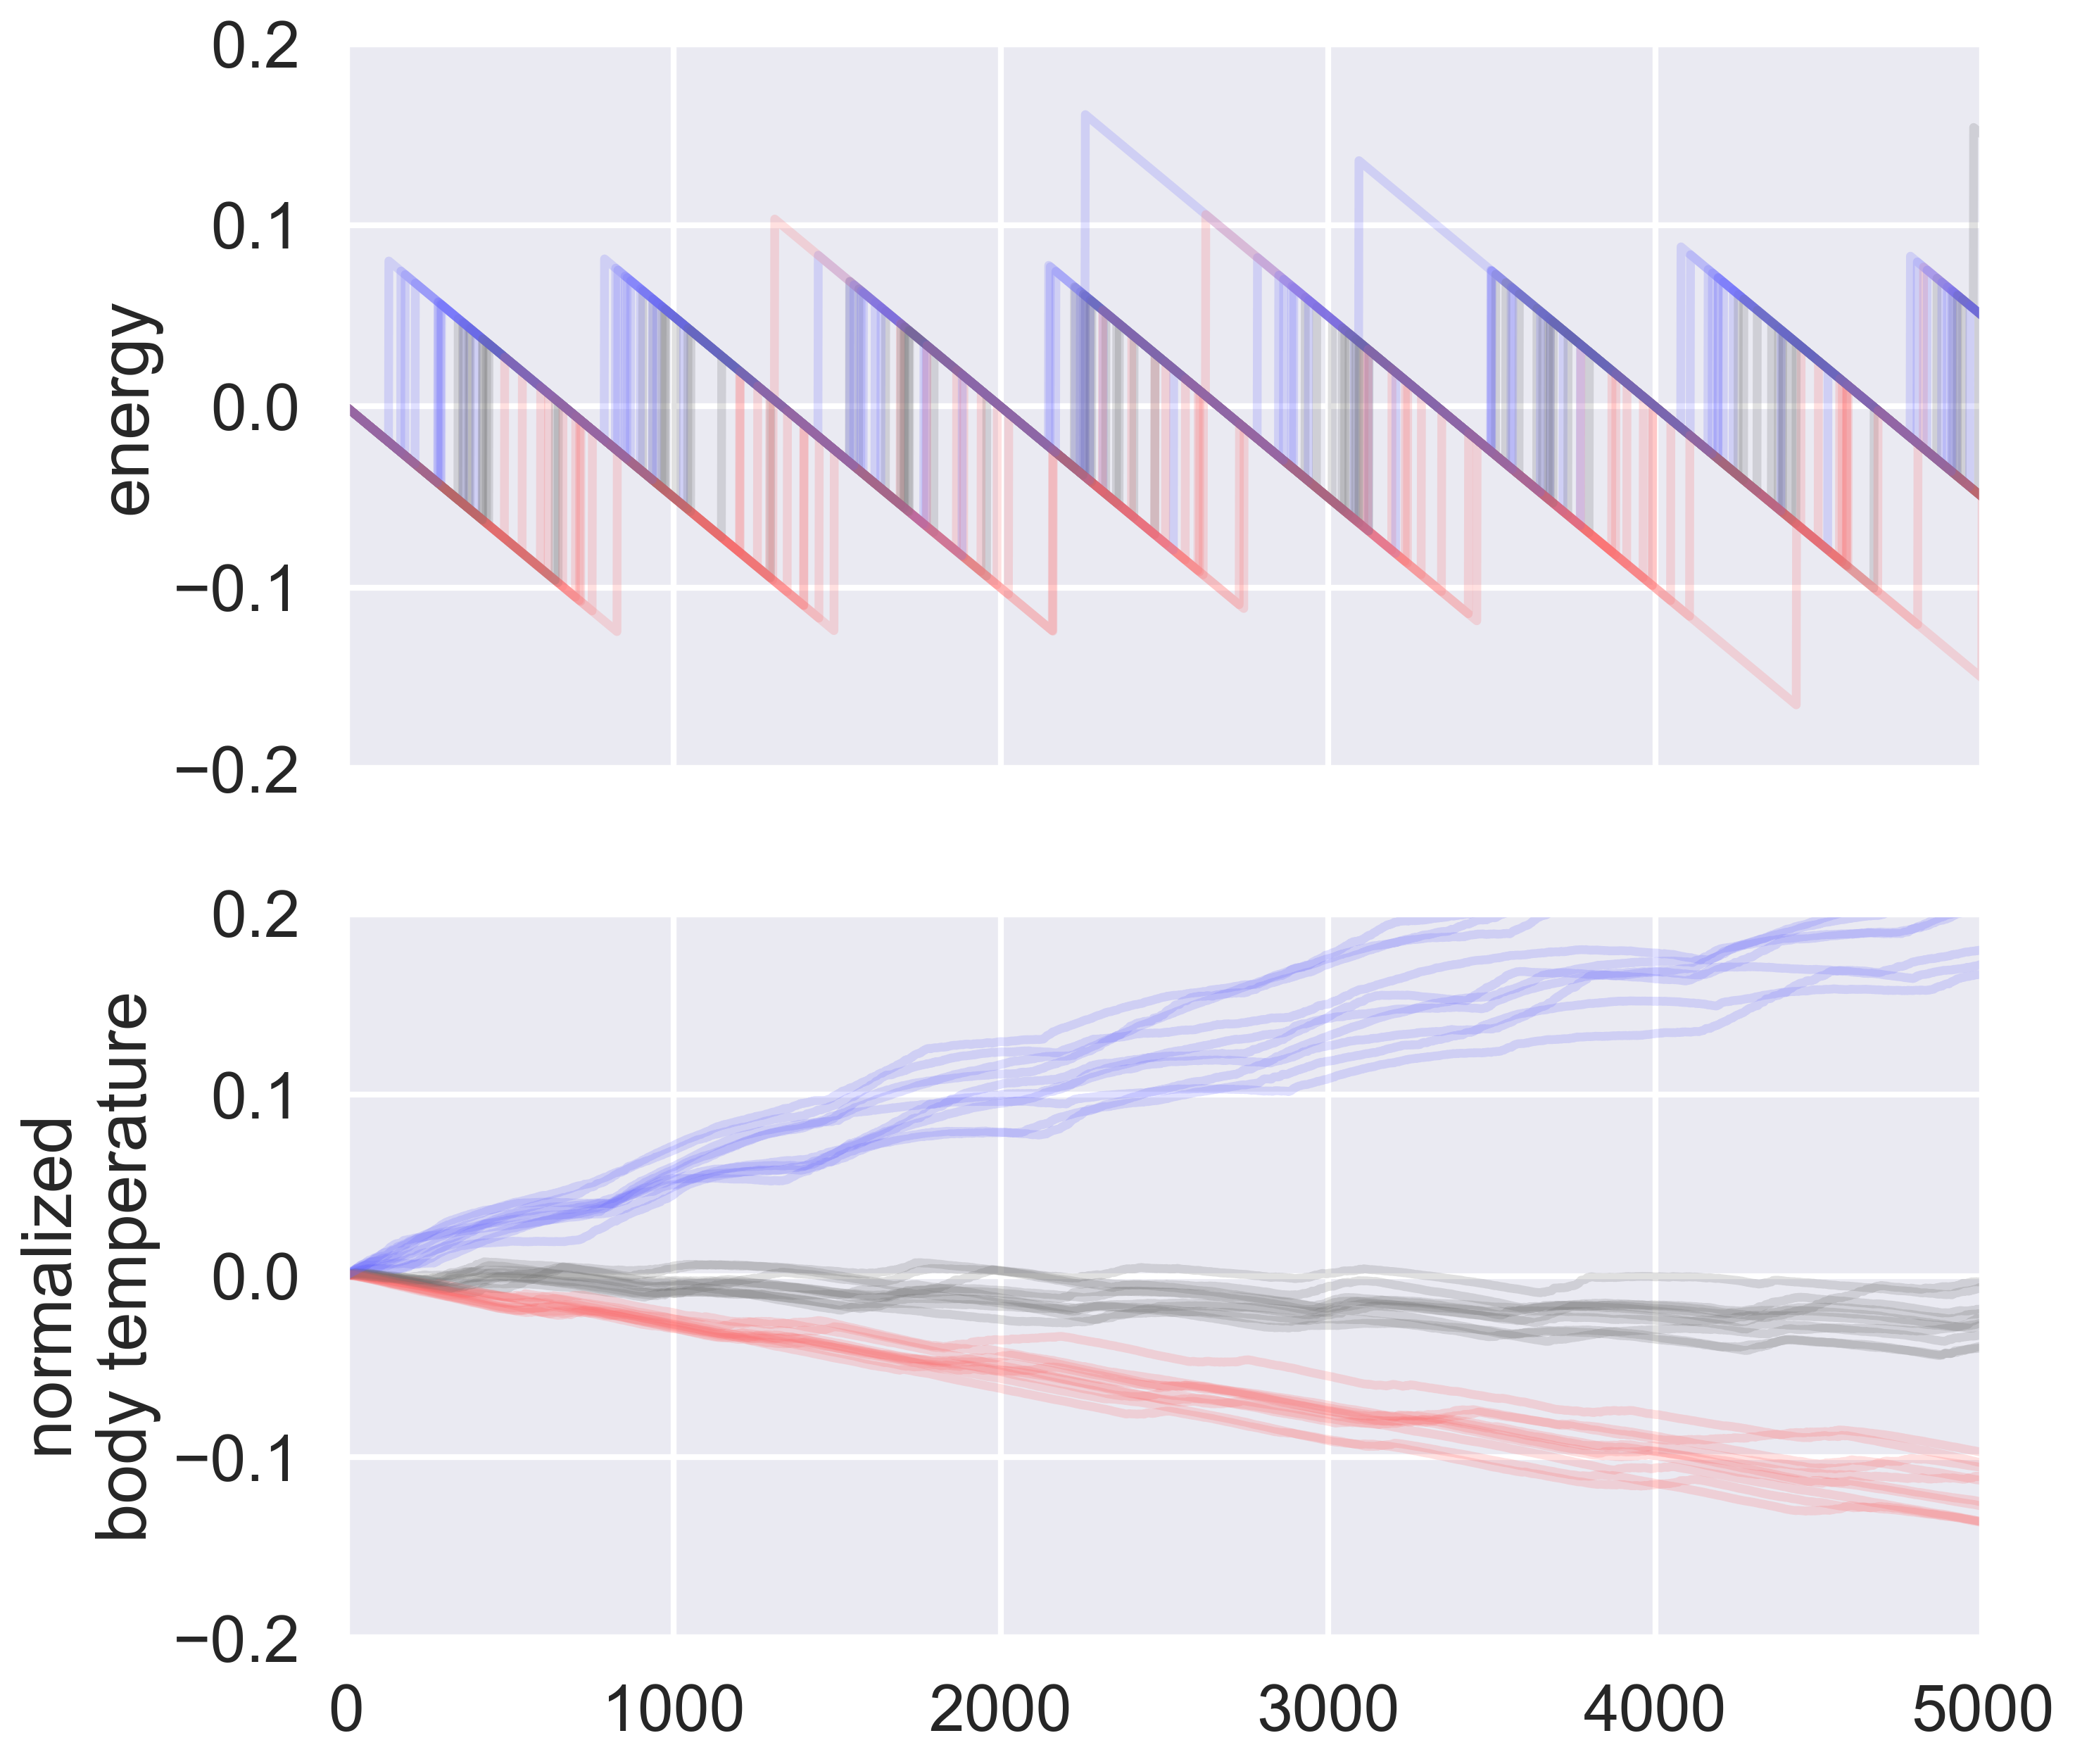

In [23]:
fig = plt.figure(figsize=(10, 10), dpi=300)
plt.legend(["energy", "core temperature", "activity", "ev action"])

time_tick = np.arange(energy_hist_n.shape[1])

start = 0
end = len(time_tick)

base = 0.4
alpha = 0.2
col = (base, base, base, alpha)
col_h = (1, base, base, alpha) 
col_l = (base, base, 1, alpha)

for n in range(N_TRIAL):
    plt.subplot(211)
    if n == N_TRIAL - 1:
        plt.ylabel("energy")
    plt.plot(time_tick[start:end], energy_hist_n[n, start:end], color=col)
    plt.plot(time_tick[start:end], energy_hist_h[n, start:end], color=col_h)
    plt.plot(time_tick[start:end], energy_hist_l[n, start:end], color=col_l)
    plt.tick_params(left = False, right = False , labelbottom = False, bottom = False)
    plt.xlim([start, end])
    plt.ylim([-0.2, 0.2])

    plt.subplot(212)
    if n == N_TRIAL - 1:
        plt.ylabel("normalized \n body temperature")
    plt.plot(time_tick[start:end], np.array(temp_hist_n[n, start:end]), color=col)
    plt.plot(time_tick[start:end], np.array(temp_hist_h[n, start:end]), color=col_h)
    plt.plot(time_tick[start:end], np.array(temp_hist_l[n, start:end]), color=col_l)
    plt.tick_params(left = False, right = False)
    plt.xlim([start, end])
    plt.ylim([-0.2, 0.2])

#     plt.subplot(313)
#     if n == N_TRIAL - 1:
#         plt.ylabel("activity")
#     plt.plot(time_tick[start:end], np.array(activity_hist[n, start:end]), color=col)
#     plt.plot(time_tick[start:end], np.array(activity_hist_h[n, start:end]), color=col_h)
#     plt.plot(time_tick[start:end], np.array(activity_hist_l[n, start:end]), color=col_l)
#     plt.tick_params(left = False, right = False)
#     plt.xlim([start, end])

    """
    plt.subplot(414)
    plt.ylabel("evaporative action")
    plt.plot(time_tick[start:end], np.array(ev_action_hist[start:end]), color="k")
    plt.plot(time_tick[start:end], np.array(ev_action_hist_h[start:end]), color="r")
    plt.plot(time_tick[start:end], np.array(ev_action_hist_l[start:end]), color="b")
    plt.tick_params(left = False, right = False)
    plt.xlim([start, end])
    # plt.ylim([-0.6, 0.6])
    """

fig.align_labels()
plt.savefig("clamp_energy_temp.png", bbox_inches='tight')

In [22]:
def barplot_annotate_brackets(num1, num2, data, center, height, yerr=None, dh=.05, barh=.05, fs=None, maxasterix=None):
    """ 
    Annotate barplot with p-values.

    :param num1: number of left bar to put bracket over
    :param num2: number of right bar to put bracket over
    :param data: string to write or number for generating asterixes
    :param center: centers of all bars (like plt.bar() input)
    :param height: heights of all bars (like plt.bar() input)
    :param yerr: yerrs of all bars (like plt.bar() input)
    :param dh: height offset over bar / bar + yerr in axes coordinates (0 to 1)
    :param barh: bar height in axes coordinates (0 to 1)
    :param fs: font size
    :param maxasterix: maximum number of asterixes to write (for very small p-values)
    """

    if type(data) is str:
        text = data
    else:
        # * is p < 0.05
        # ** is p < 0.005
        # *** is p < 0.0005
        # etc.
        text = ''
        p = .05

        while data < p:
            text += '*'
            p /= 10.

            if maxasterix and len(text) == maxasterix:
                break

        if len(text) == 0:
            text = 'n. s.'

    lx, ly = center[num1], height[num1]
    rx, ry = center[num2], height[num2]

    if yerr:
        ly += yerr[num1]
        ry += yerr[num2]

    ax_y0, ax_y1 = plt.gca().get_ylim()
    dh *= (ax_y1 - ax_y0)
    barh *= (ax_y1 - ax_y0)

    y = max(ly, ry) + dh

    barx = [lx, lx, rx, rx]
    bary = [y, y+barh, y+barh, y]
    mid = ((lx+rx)/2, y+barh)

    plt.plot(barx, bary, c='black')

    kwargs = dict(ha='center', va='bottom')
    if fs is not None:
        kwargs['fontsize'] = fs

    plt.text(*mid, text, **kwargs)

[ Shapiro-Wilk normal test: Testing of Normality ]
Normal ShapiroResult(statistic=0.9673683047294617, pvalue=0.8654304146766663)
High ShapiroResult(statistic=0.9036215543746948, pvalue=0.23998388648033142)
Low ShapiroResult(statistic=0.9032320380210876, pvalue=0.23765698075294495)
--> p > 0.05: Normal dist. 😃

[ F Test: Testing of Equi-Variance ]
High BartlettResult(statistic=1.6188026110968423, pvalue=0.2032588272184563)
Low BartlettResult(statistic=5.666377117867952, pvalue=0.017293134921404628)
--> p > 0.05: Equal Variance 😃

normal vs high:  Ttest_indResult(statistic=17.65166673083296, pvalue=1.3113673422419992e-11)
normal vs low:  Ttest_indResult(statistic=-25.07085837156486, pvalue=8.21443305549316e-12)


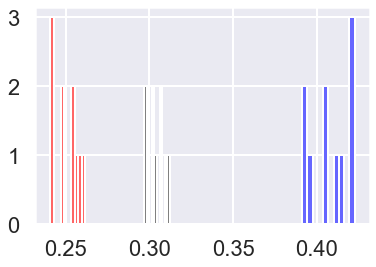

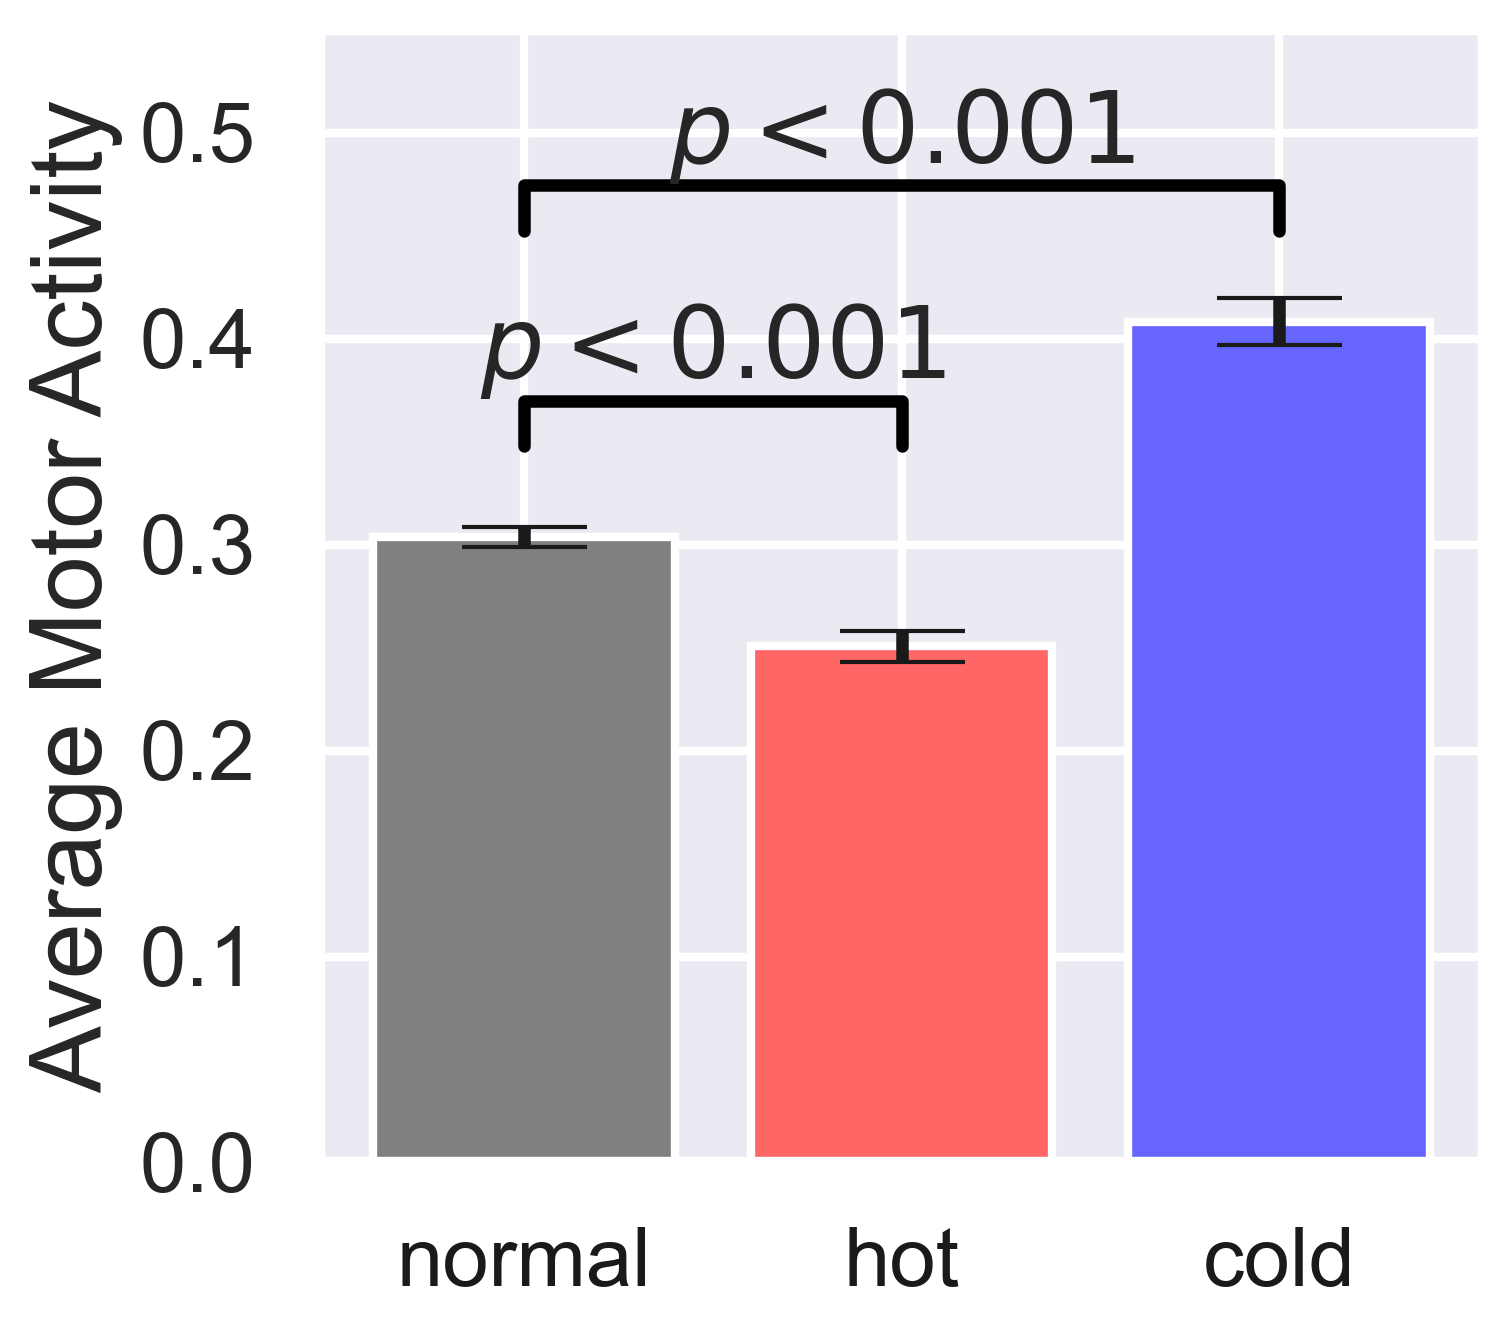

In [23]:
from scipy import stats

colors = [(0.5, 0.5, 0.5), (1, base, base), (base, base, 1)]

print("[ Shapiro-Wilk normal test: Testing of Normality ]")
print("Normal", stats.shapiro(average_activity_n))
print("High", stats.shapiro(average_activity_h))
print("Low", stats.shapiro(average_activity_l))
print("--> p > 0.05: Normal dist. 😃")
print()
print("[ F Test: Testing of Equi-Variance ]")
print("High", stats.bartlett(average_activity_n, average_activity_h))
print("Low", stats.bartlett(average_activity_n, average_activity_l))
print("--> p > 0.05: Equal Variance 😃")


plt.hist(average_activity_n, color=colors[0])
plt.hist(average_activity_h, color=colors[1])
plt.hist(average_activity_l, color=colors[2])

ttest_normal_high = stats.ttest_ind(average_activity_n, average_activity_h, equal_var=False)  # Welch's t test
ttest_normal_low = stats.ttest_ind(average_activity_n, average_activity_l, equal_var=False)   # Welch's t test

print()
print("normal vs high: ", ttest_normal_high)
print("normal vs low: ", ttest_normal_low)

bars = [0, 1, 2] #["normal", "high", "low"]
heights = [np.mean(average_activity_n), np.mean(average_activity_h), np.mean(average_activity_l)]

plt.figure(figsize=(5, 5), dpi=300)
plt.bar(x=bars,
        height=heights,
        yerr=[np.std(average_activity_n), np.std(average_activity_h), np.std(average_activity_l)],
        color=colors,
       capsize=15)

barplot_annotate_brackets(0, 1, "$p < 0.001$", bars, heights, dh=.1)  # vs. High
barplot_annotate_brackets(0, 2, "$p < 0.001$", bars, heights, dh=.1)  # vs. Low

plt.ylabel("Average Motor Activity")
plt.ylim([0, 0.55])
plt.xticks(bars, ["normal", "hot", "cold"], color='k')
plt.tick_params(labelsize=20)

plt.savefig("activity_test.png", bbox_inches='tight')

In [28]:
#correct if the population S.D. is expected to be equal for the two groups.
def cohen_d(x,y):
    nx = len(x)
    ny = len(y)
    dof = nx + ny - 2
    return (np.mean(x) - np.mean(y)) / np.sqrt(((nx-1)*np.std(x, ddof=1) ** 2 + (ny-1)*np.std(y, ddof=1) ** 2) / dof)

print("[ Calculation of Cohen's d ]")
print("normal-high: ", cohen_d(average_activity_n, average_activity_h))
print("normal-low", cohen_d(average_activity_n, average_activity_l))

[ Calculation of Cohen's d ]
normal-high:  7.8940653452627965
normal-low -11.212028714617743


# Response to the Perturbation

In [29]:
WINDOW_AVE = 100
MAX_DATA = 30000
PERTURBATION_P = 0.3
PERTURBATION_N = -0.3
TIME_PTB = 2500

In [30]:
env = get_env(seed=50)

energy_hist_pp = sliceable_deque(maxlen=MAX_DATA)
temp_hist_pp = sliceable_deque(maxlen=MAX_DATA)
activity_hist_pp = sliceable_deque(maxlen=MAX_DATA)
ev_action_hist_pp = sliceable_deque(maxlen=MAX_DATA)

with agent.eval_mode():
    total_step = 0
    energy_record = deque(maxlen=WINDOW_AVE)
    temp_record = deque(maxlen=WINDOW_AVE)
    activity_record = deque(maxlen=WINDOW_AVE)
    ev_action_record = deque(maxlen=WINDOW_AVE)

    obs = env.reset()

    for i in tqdm.tqdm(range(MAX_DATA)):
        action = agent.act(obs)
        total_step += 1

        obs, r, done, _ = env.step(action)

        if i == TIME_PTB:
            key_e, key_t = env.internal_state.keys()
            env.internal_state[key_t] = 0.0
            env.thermal_model.reset(env.decode_temperature(PERTURBATION_P))
            obs = env.get_current_obs().astype(np.float32)

        energy_now, temp_now = env.get_interoception()
        motor_action = 2 * (action[:-1] - 0.5)
        activity = np.sqrt(sum(np.square(motor_action))/motor_action.size)
        evaporative_action = 2 * (action[-1] - 0.5)

        energy_record.append(energy_now)
        temp_record.append(temp_now)
        activity_record.append(activity)
        ev_action_record.append(evaporative_action)

        energy_hist_pp.append(energy_now)
        temp_hist_pp.append(temp_now)
        activity_hist_pp.append(np.mean(activity_record))
        ev_action_hist_pp.append(np.mean(ev_action_record))

        if done:
            logger.info("Reset.: " + str(total_step))
            break
env.close()

 72%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                          | 21721/30000 [01:26<00:33, 250.55it/s]


KeyboardInterrupt: 

In [ ]:
env = get_env(seed=50)

energy_hist_pn = sliceable_deque(maxlen=MAX_DATA)
temp_hist_pn = sliceable_deque(maxlen=MAX_DATA)
activity_hist_pn = sliceable_deque(maxlen=MAX_DATA)
ev_action_hist_pn = sliceable_deque(maxlen=MAX_DATA)

with agent.eval_mode():
    total_step = 0
    energy_record = deque(maxlen=WINDOW_AVE)
    temp_record = deque(maxlen=WINDOW_AVE)
    activity_record = deque(maxlen=WINDOW_AVE)
    ev_action_record = deque(maxlen=WINDOW_AVE)

    obs = env.reset()

    for i in tqdm.tqdm(range(MAX_DATA)):
        action = agent.act(obs)
        total_step += 1

        obs, r, done, _ = env.step(action)

        if i == TIME_PTB:
            key_e, key_t = env.internal_state.keys()
            env.internal_state[key_t] = 0.0
            env.thermal_model.reset(env.decode_temperature(PERTURBATION_N))
            obs = env.get_current_obs().astype(np.float32)

        energy_now, temp_now = env.get_interoception()
        motor_action = 2 * (action[:-1] - 0.5)
        activity = np.sqrt(sum(np.square(motor_action))/motor_action.size)
        evaporative_action = 2 * (action[-1] - 0.5)

        energy_record.append(energy_now)
        temp_record.append(temp_now)
        activity_record.append(activity)
        ev_action_record.append(evaporative_action)

        energy_hist_pn.append(energy_now)
        temp_hist_pn.append(temp_now)
        activity_hist_pn.append(np.mean(activity_record))
        ev_action_hist_pn.append(np.mean(ev_action_record))

        if done:
            logger.info("Reset.: " + str(total_step))
            break
env.close()

In [ ]:
fig = plt.figure(figsize=(20, 20), dpi=300)

time_tick = np.arange(len(energy_hist_pp))

start = 0
end = MAX_DATA

plt.subplot(411)
plt.ylabel("energy")
plt.plot(time_tick[start:end], energy_hist_pp[start:end], color=(1,0.3,0.3,0.6))
plt.tick_params(left = False, right = False , labelbottom = False, bottom = False)
plt.xlim([start, end])

plt.subplot(412)
plt.ylabel("temp")
plt.plot(time_tick[start:end], np.array(temp_hist_pp[start:end]), color=(1,0,0,0.6))
plt.scatter([TIME_PTB], [0.3], marker="*", color="k", s=400)
plt.tick_params(left = False, right = False , labelbottom = False, bottom = False)
plt.xlim([start, end])

plt.subplot(413)
plt.ylabel("activity")
plt.plot(time_tick[start:end], np.array(activity_hist_pp[start:end]), color=(1,0.3,1,0.6))
plt.tick_params(left = False, right = False , labelbottom = False, bottom = False)
plt.xlim([start, end])

plt.subplot(414)
plt.ylabel("ev action")
plt.plot(time_tick[start:end], np.array(ev_action_hist_pp[start:end]), color=(0.3,0.3,1,0.6))
plt.tick_params(left = False, right = False)
plt.xlim([start, end])

fig.align_labels()

NameError: name 'energy_hist_pn' is not defined

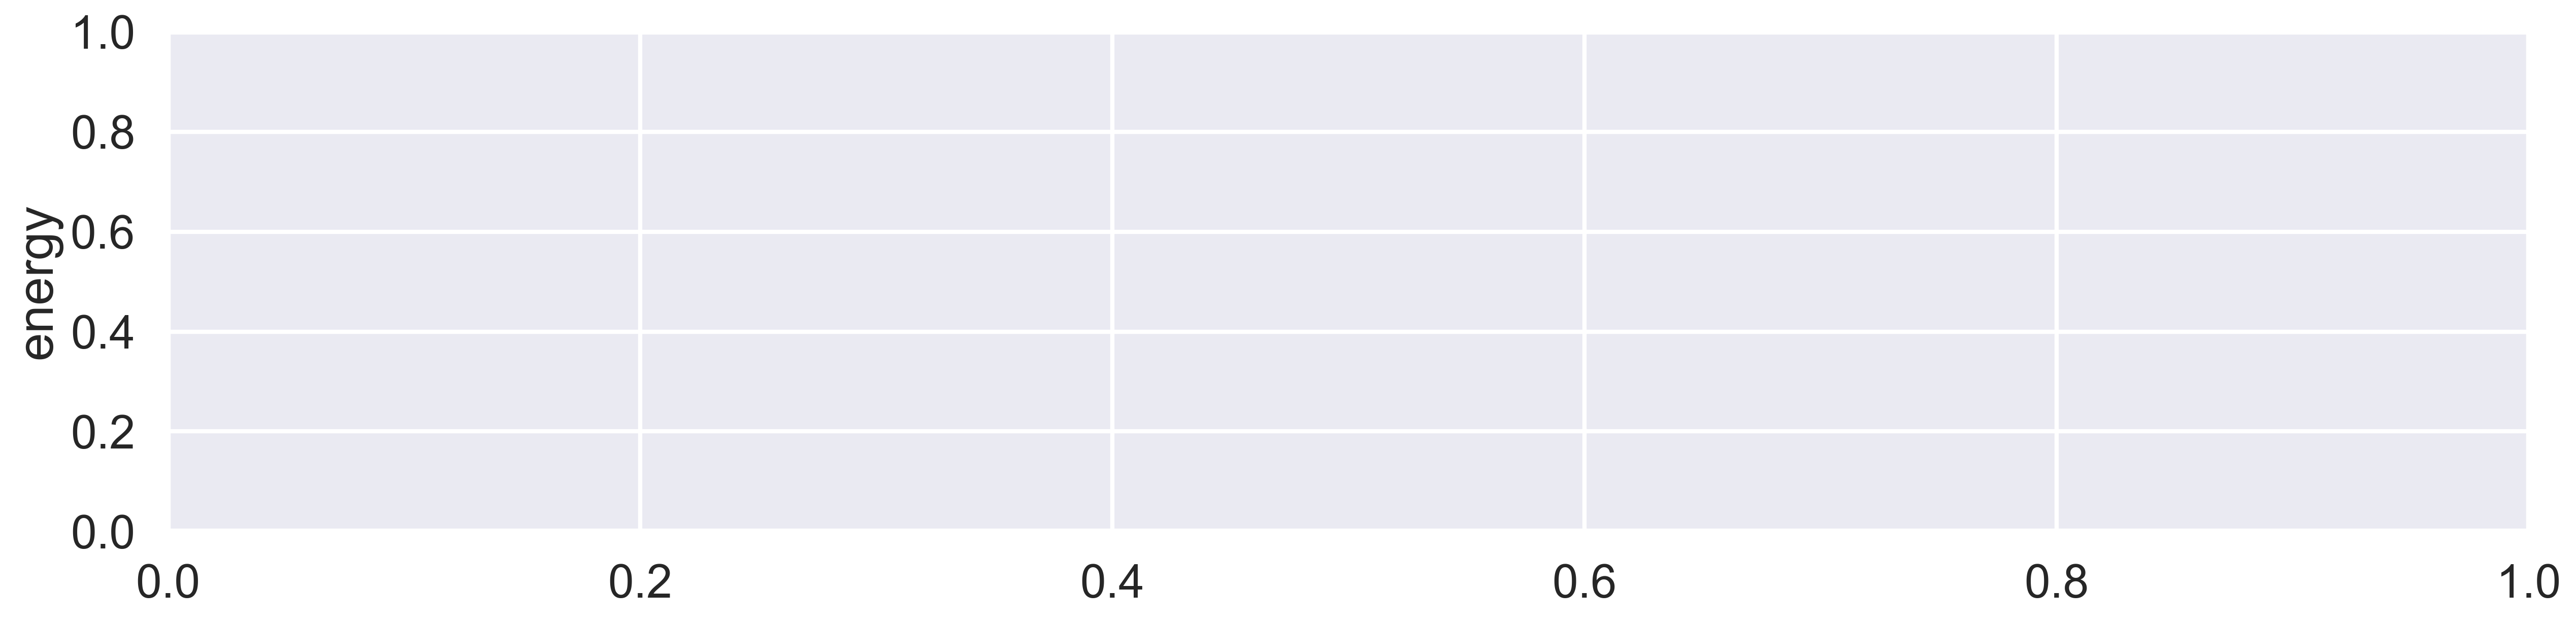

In [31]:
fig = plt.figure(figsize=(20, 20), dpi=300)

time_tick = np.arange(len(energy_hist_pp))

start = 0
end = MAX_DATA

plt.subplot(411)
plt.ylabel("energy")
plt.plot(time_tick[start:end], energy_hist_pn[start:end], color=(1,0.3,0.3,0.6))
plt.tick_params(left = False, right = False , labelbottom = False, bottom = False)
plt.xlim([start, end])

plt.subplot(412)
plt.ylabel("temp")
plt.plot(time_tick[start:end], np.array(temp_hist_pn[start:end]), color=(1,0,0,0.6))
plt.scatter([TIME_PTB], [0.3], marker="*", color="k", s=400)
plt.tick_params(left = False, right = False , labelbottom = False, bottom = False)
plt.xlim([start, end])

plt.subplot(413)
plt.ylabel("activity")
plt.plot(time_tick[start:end], np.array(activity_hist_pn[start:end]), color=(1,0.3,1,0.6))
plt.tick_params(left = False, right = False , labelbottom = False, bottom = False)
plt.xlim([start, end])

plt.subplot(414)
plt.ylabel("ev action")
plt.plot(time_tick[start:end], np.array(ev_action_hist_pn[start:end]), color=(0.3,0.3,1,0.6))
plt.tick_params(left = False, right = False)
plt.xlim([start, end])

fig.align_labels()

In [ ]:
fig = plt.figure(figsize=(15, 15), dpi=300)

fontsize=25
time_tick = np.arange(len(energy_hist_pp))

start = 0
end = MAX_DATA

c_ptbp = (1,0.3,0.3,0.55)
c_ptbn = (0.3,0.3,1,0.55)

plt.subplot(411)
plt.ylabel("Normalized\nBody Temperature", fontsize=fontsize)
plt.plot(time_tick[start:end], np.array(temp_hist_pp[start:end]), color=c_ptbp)
plt.plot(time_tick[start:end], np.array(temp_hist_pn[start:end]), color=c_ptbn)
plt.scatter([TIME_PTB], [0.6], marker="*", color="k", s=100)
plt.ylim([-0.7, 0.7])
plt.xlim([start, end])
plt.tick_params(left = False, right = False , labelbottom = False, bottom = False)
plt.tick_params(labelsize=30)

plt.subplot(412)
plt.ylabel("Energy Level", fontsize=fontsize)
plt.plot(time_tick[start:end], energy_hist_pp[start:end], color=c_ptbp)
plt.plot(time_tick[start:end], energy_hist_pn[start:end], color=c_ptbn)
plt.tick_params(left = False, right = False , labelbottom = False, bottom = False)
plt.plot([TIME_PTB, TIME_PTB], [-0.3, 0.3], color=(0, 0, 0, 0.3))
plt.xlim([start, end])
plt.ylim([-0.2, 0.2])
plt.tick_params(labelsize=30)

plt.subplot(413)
plt.ylabel("Motor Activity", fontsize=fontsize)
plt.plot(time_tick[start:end], np.array(activity_hist_pp[start:end]), color=c_ptbp)
plt.plot(time_tick[start:end], np.array(activity_hist_pn[start:end]), color=c_ptbn)
plt.plot([TIME_PTB, TIME_PTB], [-0.2, 0.6], color=(0, 0, 0, 0.3))
plt.tick_params(left = False, right = False , labelbottom = False, bottom = False)
plt.xlim([start, end])
plt.ylim([0.1, 0.6])
plt.tick_params(labelsize=30)

plt.subplot(414)
plt.ylabel("Evaporative\nAction", fontsize=fontsize)
plt.plot(time_tick[start:end], np.array(ev_action_hist_pp[start:end]), color=c_ptbp)
plt.plot(time_tick[start:end], np.array(ev_action_hist_pn[start:end]), color=c_ptbn)
plt.plot([TIME_PTB, TIME_PTB], [-0.5, 0.5], color=(0, 0, 0, 0.3))
plt.tick_params(left = False, right = False)
plt.xlim([start, end])
plt.ylim([-0.3, 0.3])
plt.xlabel("Time Step", fontsize=fontsize)
plt.tick_params(labelsize=30)

#fig.align_labels()
fig.align_ylabels()
plt.savefig("response_ptb_03.png", bbox_inches="tight")

In [ ]:
print(env.decode_temperature(0.3))
print(env.decode_temperature(0.))
print(env.decode_temperature(-0.3))

In [ ]:
env = get_env(seed=50)

with agent.eval_mode():
    total_step = 0
    obs = env.reset()

    for i in tqdm.tqdm(range(20000)):
        action = agent.act(obs)
        total_step += 1

        obs, r, done, _ = env.step(action)
        env.render()

        if i == TIME_PTB:
            key_e, key_t = env.internal_state.keys()
            env.internal_state[key_t] = 0.0
            env.thermal_model.reset(env.decode_temperature(PERTURBATION_P))
            obs = env.get_current_obs().astype(np.float32)

        if done:
            logger.info("Reset.: " + str(total_step))
            break
env.close()

In [ ]:
average_activity_h.reshape(10)

# Summary 

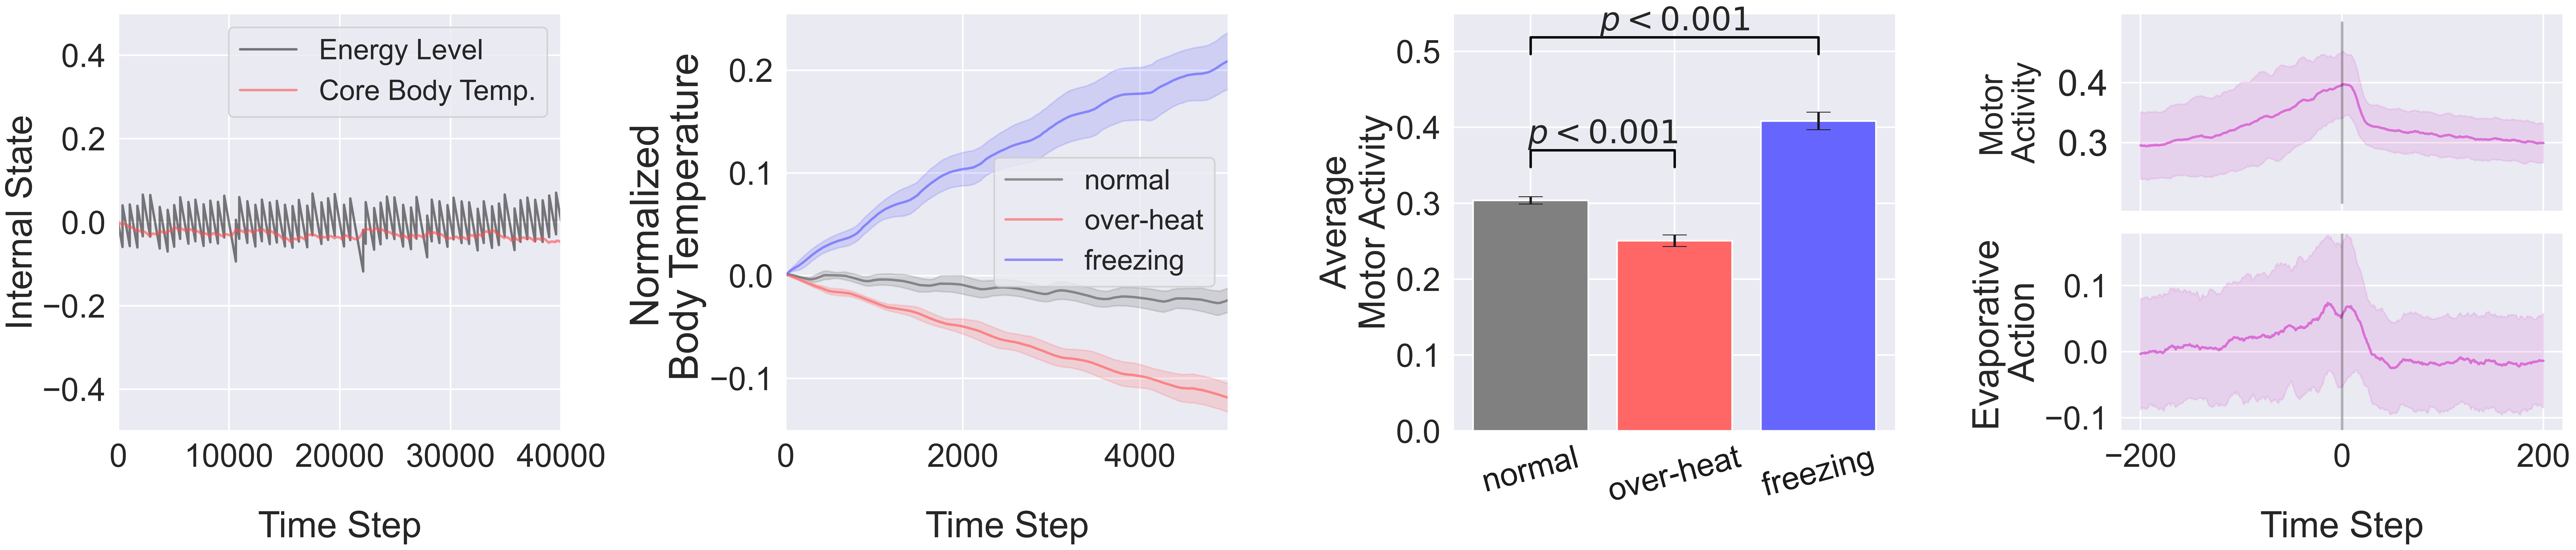

In [32]:
fontsize = 45
labelsize = 40

scale = 1.5
fig = plt.figure(figsize=(int(30*scale), int(7*scale)), dpi=300)

plt.subplot2grid((2, 4), (0, 0), rowspan=2)
time_tick = np.arange(len(energy_hist))

start = 0
end = 40000

plt.plot(time_tick[start:end], energy_hist[start:end], color=(0,0,0,0.5))
plt.plot(time_tick[start:end], np.array(temp_hist[start:end]), color=(1,.3,.3,0.6))
# plt.tick_params(left = False, right = False , labelbottom = False, bottom = False)
plt.xlim([start, end])
plt.ylim([-0.3, 0.3])

plt.ylabel("Internal State", fontsize=fontsize)
plt.xlabel("Time Step", fontsize=fontsize)
plt.ylim([-0.5, 0.5])
plt.xlim([0, 40000])
#plt.xticks([10000 * i for i in range(5)])
plt.tick_params(labelsize=labelsize)

plt.legend(["Energy Level", "Core Body Temp."], prop={'size': 35})



plt.subplot2grid((2, 4), (0, 1), rowspan=2)

time_tick = np.arange(len(energy_hist_n.mean(axis=0)))

start = 0
end = len(time_tick)

base = 0.4
col = (base, base, base, 0.7)
col_h = (1, base, base, 0.7) 
col_l = (base, base, 1, 0.7)

colf = (base, base, base, 0.2)
col_hf = (1, base, base, 0.2) 
col_lf = (base, base, 1, 0.2)

plt.ylabel("Normalized\n Body Temperature", fontsize=50)
plt.plot(time_tick[start:end], np.array(temp_hist_n.mean(axis=0)[start:end]), color=col)
plt.fill_between(time_tick[start:end],
                 np.array(temp_hist_n.mean(axis=0)[start:end]) + np.array(temp_hist_n.std(axis=0)[start:end]),
                 np.array(temp_hist_n.mean(axis=0)[start:end]) - np.array(temp_hist_n.std(axis=0)[start:end]),
                 color = colf)

plt.plot(time_tick[start:end], np.array(temp_hist_h.mean(axis=0)[start:end]), color=col_h)
plt.fill_between(time_tick[start:end],
                 np.array(temp_hist_h.mean(axis=0)[start:end]) + np.array(temp_hist_h.std(axis=0)[start:end]),
                 np.array(temp_hist_h.mean(axis=0)[start:end]) - np.array(temp_hist_h.std(axis=0)[start:end]),
                 color = col_hf)

plt.plot(time_tick[start:end], np.array(temp_hist_l.mean(axis=0)[start:end]), color=col_l)
plt.fill_between(time_tick[start:end],
                 np.array(temp_hist_l.mean(axis=0)[start:end]) + np.array(temp_hist_l.std(axis=0)[start:end]),
                 np.array(temp_hist_l.mean(axis=0)[start:end]) - np.array(temp_hist_l.std(axis=0)[start:end]),
                 color = col_lf)

#plt.tick_params(left = False, right = False , labelbottom = False, bottom = False)
plt.xlim([start, end])
plt.tick_params(labelsize=labelsize)
plt.xlabel("Time Step", fontsize=fontsize)

fig.align_labels()
plt.legend(["normal", "over-heat", "freezing"], prop={'size': 35})


plt.subplot2grid((2, 4), (0, 2), rowspan=2)

bars = [0, 1, 2] #["normal", "high", "low"]
heights = [np.mean(average_activity_n), np.mean(average_activity_h), np.mean(average_activity_l)]

plt.bar(x=bars,
        height=heights,
        yerr=[np.std(average_activity_n), np.std(average_activity_h), np.std(average_activity_l)],
        color=colors,
       capsize=15)

barplot_annotate_brackets(0, 1, "$p < 0.001$", bars, heights, dh=.1, fs=40)  # vs. High
barplot_annotate_brackets(0, 2, "$p < 0.001$", bars, heights, dh=.1, fs=40)  # vs. Low

plt.ylabel("Average\nMotor Activity", fontsize=fontsize)
plt.ylim([0, 0.55])
plt.xticks(bars, ["normal", "over-heat", "freezing"], color='k', rotation=15)
plt.tick_params(labelsize=labelsize)


plt.subplot2grid((2, 4), (0, 3), rowspan=1)
window_size = 200
x_tick = np.arange(-window_size, window_size + 1)

plt.plot(x_tick, average_activity, color="orchid")
plt.fill_between(x_tick,
                 average_activity + std_activity,
                 average_activity - std_activity,
                 color="orchid", alpha=0.2)
plt.plot([0, 0], [0.2, 0.5], color=(0, 0, 0, 0.3))

plt.ylabel("Motor\nActivity", fontsize=labelsize)
plt.tick_params(left = False, right = False , labelbottom = False, bottom = False)
plt.tick_params(labelsize=fontsize)
#plt.ylim([0.25, 0.48])
plt.yticks([0.3, 0.4])


plt.subplot2grid((2, 4), (1, 3), rowspan=1)
plt.plot(x_tick, average_eva, color="orchid")
plt.fill_between(x_tick,
                 average_eva + std_eva,
                 average_eva - std_eva,
                 color="orchid", alpha=0.2)
plt.plot([0, 0], [-0.15, 0.2], color=(0, 0, 0, 0.3))

plt.ylabel("Evaporative\nAction", fontsize=fontsize)
plt.xlabel("Time Step", fontsize=fontsize)
plt.tick_params(labelsize=labelsize)
plt.ylim([-0.12, 0.18])
plt.yticks([-0.1, 0, 0.1])

fig.align_labels()
plt.tight_layout()

plt.savefig("thermal_stats.png", bbox_inches="tight")

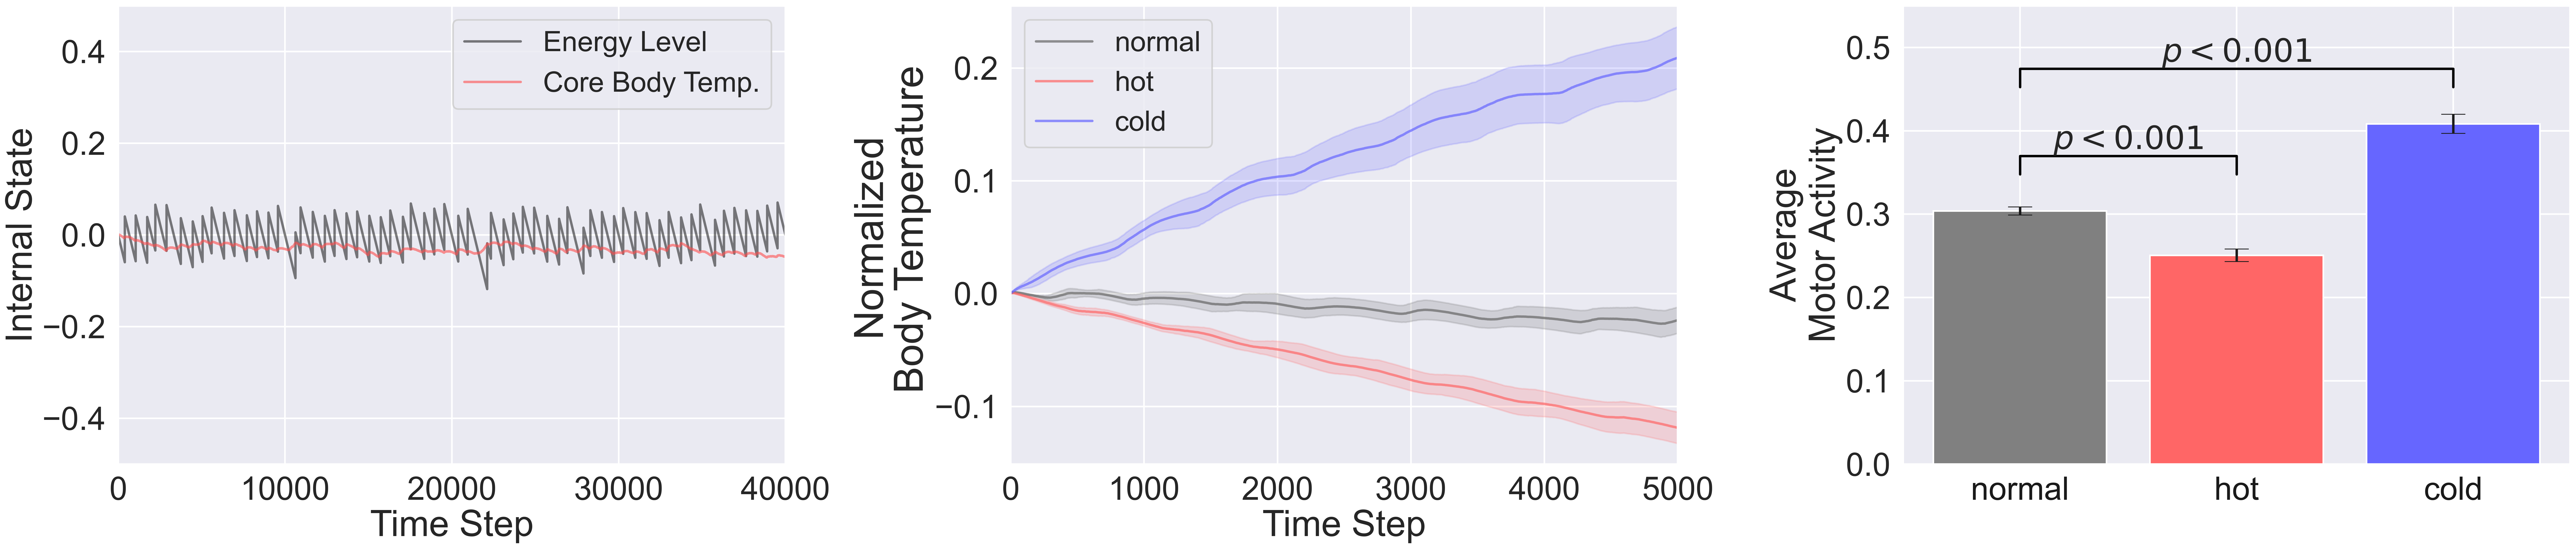

In [25]:
fontsize = 45
labelsize = 40

scale = 1.5
fig = plt.figure(figsize=(int(30*scale), int(7*scale)), dpi=300)

plt.subplot(131)
time_tick = np.arange(len(energy_hist))

start = 0
end = 40000

plt.plot(time_tick[start:end], energy_hist[start:end], color=(0,0,0,0.5))
plt.plot(time_tick[start:end], np.array(temp_hist[start:end]), color=(1,.3,.3,0.6))
# plt.tick_params(left = False, right = False , labelbottom = False, bottom = False)
plt.xlim([start, end])
plt.ylim([-0.3, 0.3])

plt.ylabel("Internal State", fontsize=fontsize)
plt.xlabel("Time Step", fontsize=fontsize)
plt.ylim([-0.5, 0.5])
plt.xlim([0, 40000])
#plt.xticks([10000 * i for i in range(5)])
plt.tick_params(labelsize=labelsize)

plt.legend(["Energy Level", "Core Body Temp."], prop={'size': 35})



plt.subplot(132)

time_tick = np.arange(len(energy_hist_n.mean(axis=0)))

start = 0
end = len(time_tick)

base = 0.4
col = (base, base, base, 0.7)
col_h = (1, base, base, 0.7) 
col_l = (base, base, 1, 0.7)

colf = (base, base, base, 0.2)
col_hf = (1, base, base, 0.2) 
col_lf = (base, base, 1, 0.2)

plt.ylabel("Normalized\n Body Temperature", fontsize=50)
plt.plot(time_tick[start:end], np.array(temp_hist_n.mean(axis=0)[start:end]), color=col)
plt.plot(time_tick[start:end], np.array(temp_hist_h.mean(axis=0)[start:end]), color=col_h)
plt.plot(time_tick[start:end], np.array(temp_hist_l.mean(axis=0)[start:end]), color=col_l)
fig.align_labels()
plt.legend(["normal", "hot", "cold"], prop={'size': 35})

plt.fill_between(time_tick[start:end],
                 np.array(temp_hist_n.mean(axis=0)[start:end]) + np.array(temp_hist_n.std(axis=0)[start:end]),
                 np.array(temp_hist_n.mean(axis=0)[start:end]) - np.array(temp_hist_n.std(axis=0)[start:end]),
                 color = colf)

plt.fill_between(time_tick[start:end],
                 np.array(temp_hist_h.mean(axis=0)[start:end]) + np.array(temp_hist_h.std(axis=0)[start:end]),
                 np.array(temp_hist_h.mean(axis=0)[start:end]) - np.array(temp_hist_h.std(axis=0)[start:end]),
                 color = col_hf)

plt.fill_between(time_tick[start:end],
                 np.array(temp_hist_l.mean(axis=0)[start:end]) + np.array(temp_hist_l.std(axis=0)[start:end]),
                 np.array(temp_hist_l.mean(axis=0)[start:end]) - np.array(temp_hist_l.std(axis=0)[start:end]),
                 color = col_lf)

#plt.tick_params(left = False, right = False , labelbottom = False, bottom = False)
plt.xlim([start, end])
plt.tick_params(labelsize=labelsize)
plt.xlabel("Time Step", fontsize=fontsize)


plt.subplot(133)

bars = [0, 1, 2] #["normal", "high", "low"]
heights = [np.mean(average_activity_n), np.mean(average_activity_h), np.mean(average_activity_l)]

plt.bar(x=bars,
        height=heights,
        yerr=[np.std(average_activity_n), np.std(average_activity_h), np.std(average_activity_l)],
        color=colors,
       capsize=15)

barplot_annotate_brackets(0, 1, "$p < 0.001$", bars, heights, dh=.1, fs=40)  # vs. High
barplot_annotate_brackets(0, 2, "$p < 0.001$", bars, heights, dh=.1, fs=40)  # vs. Low

plt.ylabel("Average\nMotor Activity", fontsize=fontsize)
plt.ylim([0, 0.55])
plt.xticks(bars, ["normal", "hot", "cold"], color='k', rotation=0)
plt.tick_params(labelsize=labelsize)

fig.align_labels()
plt.tight_layout()

plt.savefig("thermal_stats3_2.png", bbox_inches="tight")

In [ ]:
x_tick

In [ ]:
average_activity

In [ ]:
from copy import deepcopy


energy_error_mean = []
temp_error_mean = []
    
for n in range(10):
    env = get_env(seed=np.random.randint(1000), n_energy=6)
    
    energy_errors = []
    temp_errors = []

    with agent.eval_mode():    
        obs = env.reset()

        for i in tqdm.tqdm(range(5000)):
            action = agent.act(obs)

            obs, r, done, _ = env.step(action)

            energy_now, temp_now = env.get_interoception()
            motor_action = 2 * (action[:-1] - 0.5)
            activity = np.sqrt(sum(np.square(motor_action))/motor_action.size)
            evaporative_action = 2 * (action[-1] - 0.5)
            
            energy_errors.append(energy_now**2)
            temp_errors.append(temp_now**2)

            if done:
                break
    
    energy_error_mean.append(np.mean(energy_errors))
    temp_error_mean.append(np.mean(temp_errors))

env.close()

eem_normal = deepcopy(energy_error_mean)
tem_normal = deepcopy(temp_error_mean)

In [ ]:
fixed_ev_action = np.linspace(0, 1, 7)
eem_fix = []
tem_fix = []
eestd_fix = []
testd_fix = []

for ev_a in tqdm.tqdm(fixed_ev_action):
    print(f"Evaporative acition: {ev_a}")
    eem = []
    tem = []
    for n in range(10):
        env = get_env(seed=np.random.randint(1000), n_energy=6)

        energy_errors = []
        temp_errors = []

        with agent.eval_mode():    
            obs = env.reset()

            for i in range(5000):
                action = agent.act(obs)
                action[-1] = ev_a

                obs, r, done, _ = env.step(action)

                energy_now, temp_now = env.get_interoception()
                motor_action = 2 * (action[:-1] - 0.5)
                activity = np.sqrt(sum(np.square(motor_action))/motor_action.size)
                evaporative_action = 2 * (action[-1] - 0.5)

                energy_errors.append(energy_now**2)
                temp_errors.append(temp_now**2)

                if done:
                    break
                    
        eem.append(np.mean(energy_errors))
        tem.append(np.mean(temp_errors))                

    eem_fix.append(np.mean(eem))
    tem_fix.append(np.mean(tem))
    eestd_fix.append(np.std(eem))
    testd_fix.append(np.std(tem))

env.close()


In [ ]:
plt.figure()

x = range(len(fixed_ev_action) + 1)
y = [np.mean(eem)] + eem_fix
err = [np.std(eem)] + eestd_fix
plt.errorbar(x, y, err)

plt.figure()
x = range(len(fixed_ev_action) + 1)
y = [np.mean(tem)] + tem_fix
err = [np.std(tem)] + testd_fix
plt.errorbar(x, y, err)

In [ ]:
plt.hist(eem)

In [ ]:
plt.hist(tem)

In [ ]:
eem_fix